<a href="https://colab.research.google.com/github/Legacy560/MTLSA25-Sales-Forecasting-Project/blob/main/Cleaning%20and%20ARIMA/MLTSA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initial Imports


In [1]:
# # Step 1: Upgrade numpy to a known compatible version
# !pip install numpy==1.24.4 --quiet

# # Step 2: Force reinstall pmdarima with no cache
!pip install pmdarima

!pip install --no-cache-dir pmdarima --quiet



  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.5 MB/s eta 0:00:00
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)


The cell below is run if the user is having difficulty installing pmdarima. This library is needed to run the auto_arima function.

In [1]:
# Uninstall numpy, scipy, and scikit-learn
!pip uninstall numpy scipy scikit-learn -y

# Install a specific, compatible version of numpy
!pip install numpy==1.24.3

# Reinstall scipy and scikit-learn
!pip install scipy scikit-learn

# Install pmdarima
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, which is not installed.
mlxtend 0.23.4 requires scipy>=1.2.1, which is not installed.
shap 0.47.2 requires scikit-learn, which is not installed.
shap 0.47.2 requires scipy, which is not installed.
umap-learn 0.5.7 requires scikit-learn>=0.22, which is not installed.
umap-learn 0.5.7 requires scipy>=1.3.1, which is not installed.
plotnine 0.14.5 requires sci

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.3 MB/s eta 0:00:00
^C
^C


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
import pylab as pl
import json
import os
import warnings
import dask.dataframe as dd
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Keras Imports (May need to upgrade numpy to use. pmdarima requires an earlier version of numpy)
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout
from keras.layers import MultiHeadAttention, Add, GlobalAveragePooling1D, Reshape
from keras.optimizers import Adam

##Accessing Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/Shareddrives/MLTSA25-Sales-Forecasting/Project

/content/drive/Shareddrives/MLTSA25-Sales-Forecasting/Project


##Data aquisition and preprocessing

In [ ]:
cal = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
salesVal = pd.read_csv('sales_train_validation.csv')
salesEval = pd.read_csv('sales_train_evaluation.csv')

In [ ]:
display(cal.head())
display(salesVal.head())
display(prices.head())

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

# **Downcast and reshape sales data into long format.**

This allows for us to merge the sales dataset with the calendar dataset. These datasets are large, however; and any operations will cause the Python session to crash. Thus, before we can do anything else, we need to deal with the storage and memory that these datasets take up. The following function helps with this task as it changes the column types to less memory-intensive ones.

In [ ]:
#This code came from: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data. I take no credit for it.

#Downcast in order to save memory
def downcast(df):

  '''
  Changes column types in the dataframe to reduce memory usage.
  Input:
    df (pandas dataframe): dataframe to be downcast.
  Output:
    df (pandas dataframe): dataframe with reduced memory usage.
  '''
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()
  for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
  return df

salesVal = downcast(salesVal)
prices = downcast(prices)
cal = downcast(cal)
salesEval = downcast(salesEval)

In [ ]:
salesValLong = salesVal.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                         var_name="d", value_name="units_sold").dropna()
#This gives us a column "d" containing each sales day. This is the same as the "d" column from calendar

In [ ]:
salesEvalLong = salesEval.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                         var_name="d", value_name="units_sold").dropna()

In [ ]:
del salesVal
del salesEval

In [ ]:
#Check for missing values
display(salesValLong.isnull().sum())
display(cal.isnull().sum())
display(prices.isnull().sum())

id            0
item_id       0
dept_id       0
cat_id        0
store_id      0
state_id      0
d             0
units_sold    0
dtype: int64

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

# Merging Datasets

In [ ]:
#Merge with Calendar dataset
salesValLong = salesValLong.merge(cal, on="d", how="left")
salesEvalLong = salesEvalLong.merge(cal, on="d", how="left")
display(salesValLong.head())

del cal

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ... wday  month  year  \
0       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
1       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
2       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
3       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
4       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   

   event_name_1 event_type_1 event_name_2 event_type_2 snap_CA  snap_TX  \
0           NaN          NaN          NaN          NaN       0        0   
1           NaN          NaN          NaN          NaN       0        0   
2           NaN          NaN          NaN          NaN       0        0   
3           NaN          NaN          NaN          NaN       0        0   
4           NaN          NaN          NaN          NaN       0        0   

   snap_WI  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 21 columns]

In [ ]:
#Merge with prices dataset
salesFull = salesValLong.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")
display(salesFull.head())
del salesValLong


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ... month  year  \
0       CA  d_1           0 2011-01-29     11101  ...     1  2011   
1       CA  d_1           0 2011-01-29     11101  ...     1  2011   
2       CA  d_1           0 2011-01-29     11101  ...     1  2011   
3       CA  d_1           0 2011-01-29     11101  ...     1  2011   
4       CA  d_1           0 2011-01-29     11101  ...     1  2011   

   event_name_1  event_type_1 event_name_2 event_type_2 snap_CA snap_TX  \
0           NaN           NaN          NaN          NaN       0       0   
1           NaN           NaN          NaN          NaN       0       0   
2           NaN           NaN          NaN          NaN       0       0   
3           NaN           NaN          NaN          NaN       0       0   
4           NaN           NaN          NaN          NaN       0       0   

   snap_WI  sell_price  
0        0         NaN  
1        0         NaN  
2        0         NaN  
3        0         NaN  
4        0         NaN  

[5 rows x 22 columns]

In [ ]:
salesEvalFull = salesEvalLong.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")
del prices
del salesEvalLong

Downcast both datasets again to improve our memory usage

In [ ]:
downcast(salesFull)
downcast(salesEvalFull)

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  units_sold       date  wm_yr_wk  ...  \
0            CA_1       CA     d_1           0 2011-01-29     11101  ...   
1            CA_1       CA     d_1           0 2011-01-29     11101  ...   
2            CA_1       CA     d_1           0 2011-01-29     11101  ...   
3            CA_1       CA     d_1           0 2011-01-29     11101  ...   
4            CA_1       CA     d_1           0 2011-01-29     11101  ...   
...           ...      ...     ...         ...        ...       ...  ...   
59181085     WI_3       WI  d_1941           1 2016-05-22     11617  ...   
59181086     WI_3       WI  d_1941           0 2016-05-22     11617  ...   
59181087     WI_3       WI  d_1941           2 2016-05-22     11617  ...   
59181088     WI_3       WI  d_1941           0 2016-05-22     11617  ...   
59181089     WI_3       WI  d_1941           1 2016-05-22     11617  ...   

         month  year  event_name_1  event_type_1 event_name_2 event_type_2  \
0            1  2011           NaN           NaN          NaN          NaN   
1            1  2011           NaN           NaN          NaN          NaN   
2            1  2011           NaN           NaN          NaN          NaN   
3            1  2011           NaN           NaN          NaN          NaN   
4            1  2011           NaN           NaN          NaN          NaN   
...        ...   ...           ...           ...          ...          ...   
59181085     5  2016           NaN           NaN          NaN          NaN   
59181086     5  2016           NaN           NaN          NaN          NaN   
59181087     5  2016           NaN           NaN          NaN          NaN   
59181088     5  2016           NaN           NaN          NaN          NaN   
59181089     5  2016           NaN           NaN          NaN          NaN   

         snap_CA snap_TX  snap_WI  sell_price  
0              0       0        0         NaN  
1              0       0        0         NaN  
2              0       0        0         NaN  
3              0       0        0         NaN  
4              0       0        0         NaN  
...          ...     ...      ...         ...  
59181085       0       0        0    2.980469  
59181086       0       0        0    2.480469  
59181087       0       0        0    3.980469  
59181088       0       0        0    1.280273  
59181089       0       0        0    1.000000  

[59181090 rows x 22 columns]

In [ ]:
salesFull.shape

(58327370, 22)

In [ ]:
display(salesFull.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [ ]:
salesFull.describe()

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


units_sold                           date      wm_yr_wk  \
count  5.832737e+07                       58327370  5.832737e+07   
mean   1.126322e+00  2013-09-11 00:00:00.000000768  1.133919e+04   
min    0.000000e+00            2011-01-29 00:00:00  1.110100e+04   
25%    0.000000e+00            2012-05-21 00:00:00  1.121700e+04   
50%    0.000000e+00            2013-09-11 00:00:00  1.133300e+04   
75%    1.000000e+00            2015-01-02 00:00:00  1.144800e+04   
max    7.630000e+02            2016-04-24 00:00:00  1.161300e+04   
std    3.873108e+00                            NaN  1.503742e+02   

               wday         month          year       snap_CA       snap_TX  \
count  5.832737e+07  5.832737e+07  5.832737e+07  5.832737e+07  5.832737e+07   
mean   3.997386e+00  6.357554e+00  2.013209e+03  3.293257e-01  3.293257e-01   
min    1.000000e+00  1.000000e+00  2.011000e+03  0.000000e+00  0.000000e+00   
25%    2.000000e+00  3.000000e+00  2.012000e+03  0.000000e+00  0.000000e+00   
50%    4.000000e+00  6.000000e+00  2.013000e+03  0.000000e+00  0.000000e+00   
75%    6.000000e+00  9.000000e+00  2.015000e+03  1.000000e+00  1.000000e+00   
max    7.000000e+00  1.200000e+01  2.016000e+03  1.000000e+00  1.000000e+00   
std    2.000652e+00  3.458773e+00  1.532086e+00  4.699684e-01  4.699684e-01   

            snap_WI    sell_price  
count  5.832737e+07  4.602796e+07  
mean   3.293257e-01           NaN  
min    0.000000e+00  1.000214e-02  
25%    0.000000e+00  2.179688e+00  
50%    0.000000e+00  3.470703e+00  
75%    1.000000e+00  5.839844e+00  
max    1.000000e+00  1.073125e+02  
std    4.699684e-01  0.000000e+00

In [ ]:
#Check for missing values in full dataset
display(salesFull.isnull().sum())

#Add total sale column
salesFull['total_sale'] = salesFull['units_sold'] * salesFull['sell_price']

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
units_sold             0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    53631910
event_type_1    53631910
event_name_2    58205410
event_type_2    58205410
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64

In [ ]:
salesFull.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ...  year  event_name_1  \
0       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
1       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
2       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
3       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
4       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI  \
0           NaN           NaN          NaN       0       0       0   
1           NaN           NaN          NaN       0       0       0   
2           NaN           NaN          NaN       0       0       0   
3           NaN           NaN          NaN       0       0       0   
4           NaN           NaN          NaN       0       0       0   

   sell_price  total_sale  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN  

[5 rows x 23 columns]

Filtering data on the base of state, Califonia


In [ ]:
salesFull=salesFull[salesFull['store_id'] == 'CA_1']
salesEvalFull=salesEvalFull[salesEvalFull['store_id'] == 'CA_1']

The rows of both of these datasets are named the same, with one exception. Each row is named with the suffix "_validation" or _"evaluation" to indicate which dataset they belong to. Before we can compare these datasets, we must change the names of the rows so they match entirely.

In [ ]:
#Change suffix in row names of salesEvalFull from "_evaluation" to "_validation"
salesEvalFull['id'] = salesEvalFull['id'].str.replace('_evaluation', '_validation')
salesEvalFull.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ... month  year  \
0       CA  d_1           0 2011-01-29     11101  ...     1  2011   
1       CA  d_1           0 2011-01-29     11101  ...     1  2011   
2       CA  d_1           0 2011-01-29     11101  ...     1  2011   
3       CA  d_1           0 2011-01-29     11101  ...     1  2011   
4       CA  d_1           0 2011-01-29     11101  ...     1  2011   

   event_name_1  event_type_1 event_name_2 event_type_2 snap_CA snap_TX  \
0           NaN           NaN          NaN          NaN       0       0   
1           NaN           NaN          NaN          NaN       0       0   
2           NaN           NaN          NaN          NaN       0       0   
3           NaN           NaN          NaN          NaN       0       0   
4           NaN           NaN          NaN          NaN       0       0   

   snap_WI  sell_price  
0        0         NaN  
1        0         NaN  
2        0         NaN  
3        0         NaN  
4        0         NaN  

[5 rows x 22 columns]

In [ ]:
display(salesFull.shape)
display(salesEvalFull.shape)

(23330948, 22)

(23672436, 22)

In [ ]:
np.random.seed(42)
random_item_ids = np.random.choice(salesFull['id'].unique(), size=10, replace=False)
display(random_item_ids)

array(['FOODS_3_439_CA_1_validation', 'HOUSEHOLD_1_472_CA_1_validation',
       'FOODS_2_135_CA_1_validation', 'HOBBIES_1_352_CA_1_validation',
       'FOODS_3_145_CA_1_validation', 'HOUSEHOLD_2_077_CA_1_validation',
       'FOODS_3_452_CA_1_validation', 'HOUSEHOLD_2_422_CA_1_validation',
       'HOUSEHOLD_2_349_CA_1_validation', 'FOODS_2_257_CA_1_validation'],
      dtype=object)

In [ ]:
salesFull = salesFull[salesFull['id'].isin(random_item_ids)]
salesEvalFull = salesEvalFull[salesEvalFull['id'].isin(random_item_ids)]

In [ ]:
#Reshape dataset so that the days are on the horizontal
salesFull = salesFull.pivot(index='id', columns='d', values='units_sold')
salesEvalFull = salesEvalFull.pivot(index='id', columns='d', values='units_sold')
# Convert column names to integers (ignoring the 'd_') and sort them
# We need to handle potential NaNs if some combinations of id and d don't exist
# though in this case, due to how the data was melted and filtered, it's less likely.
# However, converting to a numeric type for sorting is the key.

# Create a list of column names (e.g., ['d_1', 'd_2', ..., 'd_1913'])
column_names = salesFull.columns.tolist()
column_names2 = salesEvalFull.columns.tolist()
# Sort the column names based on the numerical part after 'd_'
# We extract the number by splitting the string and converting to integer
sorted_column_names = sorted(column_names, key=lambda x: int(x.split('_')[1]))
sorted_column_names2 = sorted(column_names2, key=lambda x: int(x.split('_')[1]))
# Reindex the DataFrame with the sorted column names
salesFull = salesFull[sorted_column_names]
salesEvalFull = salesEvalFull[sorted_column_names2]
#salesEvalFull1 = salesEvalFull1.pivot(index='id', columns='d', values='units_sold')

In [ ]:
display(salesFull.shape)
display(salesEvalFull.shape)

(10, 1913)

(10, 1941)

In [8]:
display(salesFull)
display(salesEvalFull)

1  2  3  4  5  6  7  8  9  10  ...  1904  \
id                                                              ...         
HOBBIES_1_352_CA_1_validation    0  0  0  0  0  0  0  0  0   0  ...     0   
HOUSEHOLD_1_472_CA_1_validation  0  1  0  0  1  0  0  1  0   0  ...     0   
HOUSEHOLD_2_077_CA_1_validation  0  0  0  0  0  0  0  0  0   0  ...     0   
HOUSEHOLD_2_349_CA_1_validation  0  5  1  0  1  0  0  0  2   0  ...     0   
HOUSEHOLD_2_422_CA_1_validation  0  0  0  0  0  0  0  0  0   1  ...     0   
FOODS_2_135_CA_1_validation      1  3  0  0  2  0  0  3  5   0  ...     3   
FOODS_2_257_CA_1_validation      0  0  0  0  0  0  0  0  0   0  ...     0   
FOODS_3_145_CA_1_validation      0  0  0  0  0  0  0  1  1   0  ...     1   
FOODS_3_439_CA_1_validation      0  0  0  0  0  0  0  0  0   0  ...     3   
FOODS_3_452_CA_1_validation      1  0  0  0  0  1  0  2  1   1  ...     0   

                                 1905  1906  1907  1908  1909  1910  1911  \
id                                                                          
HOBBIES_1_352_CA_1_validation       0     1     0     0     2     0     2   
HOUSEHOLD_1_472_CA_1_validation     0     0     0     0     0     0     0   
HOUSEHOLD_2_077_CA_1_validation     1     0     1     1     0     0     0   
HOUSEHOLD_2_349_CA_1_validation     0     3     0     1     0     0     0   
HOUSEHOLD_2_422_CA_1_validation     1     0     0     0     0     0     1   
FOODS_2_135_CA_1_validation         0     0     0     4     0     6     1   
FOODS_2_257_CA_1_validation         0     0     0     4     2     2     1   
FOODS_3_145_CA_1_validation         0     0     0     0     0     0     0   
FOODS_3_439_CA_1_validation         7    16     7     3     1     4     2   
FOODS_3_452_CA_1_validation         1     0     0     1     1     0     0   

                                 1912  1913  
id                                           
HOBBIES_1_352_CA_1_validation       0     1  
HOUSEHOLD_1_472_CA_1_validation     0     0  
HOUSEHOLD_2_077_CA_1_validation     0     1  
HOUSEHOLD_2_349_CA_1_validation     0     0  
HOUSEHOLD_2_422_CA_1_validation     0     0  
FOODS_2_135_CA_1_validation         0     0  
FOODS_2_257_CA_1_validation         0     2  
FOODS_3_145_CA_1_validation         1     1  
FOODS_3_439_CA_1_validation         4     6  
FOODS_3_452_CA_1_validation         0     1  

[10 rows x 1913 columns]

1  2  3  4  5  6  7  8  9  10  ...  1932  \
id                                                              ...         
HOBBIES_1_352_CA_1_validation    0  0  0  0  0  0  0  0  0   0  ...     1   
HOUSEHOLD_1_472_CA_1_validation  0  1  0  0  1  0  0  1  0   0  ...     0   
HOUSEHOLD_2_077_CA_1_validation  0  0  0  0  0  0  0  0  0   0  ...     1   
HOUSEHOLD_2_349_CA_1_validation  0  5  1  0  1  0  0  0  2   0  ...     0   
HOUSEHOLD_2_422_CA_1_validation  0  0  0  0  0  0  0  0  0   1  ...     0   
FOODS_2_135_CA_1_validation      1  3  0  0  2  0  0  3  5   0  ...     2   
FOODS_2_257_CA_1_validation      0  0  0  0  0  0  0  0  0   0  ...     1   
FOODS_3_145_CA_1_validation      0  0  0  0  0  0  0  1  1   0  ...     1   
FOODS_3_439_CA_1_validation      0  0  0  0  0  0  0  0  0   0  ...     2   
FOODS_3_452_CA_1_validation      1  0  0  0  0  1  0  2  1   1  ...     0   

                                 1933  1934  1935  1936  1937  1938  1939  \
id                                                                          
HOBBIES_1_352_CA_1_validation       2     3     1     0     0     2     1   
HOUSEHOLD_1_472_CA_1_validation     0     0     0     0     0     0     0   
HOUSEHOLD_2_077_CA_1_validation     0     0     0     0     0     1     0   
HOUSEHOLD_2_349_CA_1_validation     2     1     2     3     3     0     0   
HOUSEHOLD_2_422_CA_1_validation     2     0     0     2     0     0     0   
FOODS_2_135_CA_1_validation         5     1     0     0     0     1     0   
FOODS_2_257_CA_1_validation         0     2     1    10     0     0     0   
FOODS_3_145_CA_1_validation         0     1     0     0     0     1     0   
FOODS_3_439_CA_1_validation         2     4     3     3     2     8     3   
FOODS_3_452_CA_1_validation         0     2     1     1     1     0     0   

                                 1940  1941  
id                                           
HOBBIES_1_352_CA_1_validation       1     1  
HOUSEHOLD_1_472_CA_1_validation     0     0  
HOUSEHOLD_2_077_CA_1_validation     0     0  
HOUSEHOLD_2_349_CA_1_validation     0     0  
HOUSEHOLD_2_422_CA_1_validation     0     0  
FOODS_2_135_CA_1_validation         0     0  
FOODS_2_257_CA_1_validation         0     0  
FOODS_3_145_CA_1_validation         2     0  
FOODS_3_439_CA_1_validation         2     4  
FOODS_3_452_CA_1_validation         0     1  

[10 rows x 1941 columns]

In [6]:
#change the index to the id column
salesFull.set_index('id', inplace=True)
salesEvalFull.set_index('id', inplace=True)


In [7]:
#Sort the row indices in salesEvalFull so they match the order in salesFull
salesEvalFull = salesEvalFull.reindex(salesFull.index)

In [ ]:
#Go through the dataset and change the days to integers. so "d_2" becomes just 2 for example
salesFull = salesFull.rename(columns=lambda x: int(x.split('_')[1]))
salesEvalFull = salesEvalFull.rename(columns=lambda x: int(x.split('_')[1]))

NameError: name 'salesFull' is not defined

We will save these datasets to our Google Drive so that we can easily recover them after the kernel resets.

In [ ]:
salesFull.to_csv('salesFull.csv')
salesEvalFull.to_csv('salesEvalFull.csv')

In [5]:
#Reading in the data
salesFull = pd.read_csv('salesFull.csv')
salesEvalFull = pd.read_csv('salesEvalFull.csv')

# Data Analysis

Ploting of time series graph with good visuals was talking a lot of time and memory so we used Power BI for visualization part.

Power BI report link: https://drive.google.com/file/d/1QHiKeDMdUiLHiZoEa3E7S19d1km1YmEw/view?usp=drive_link



Time series graph for Total UNIT_SOLD by YEARMONTH and ITEM_ID

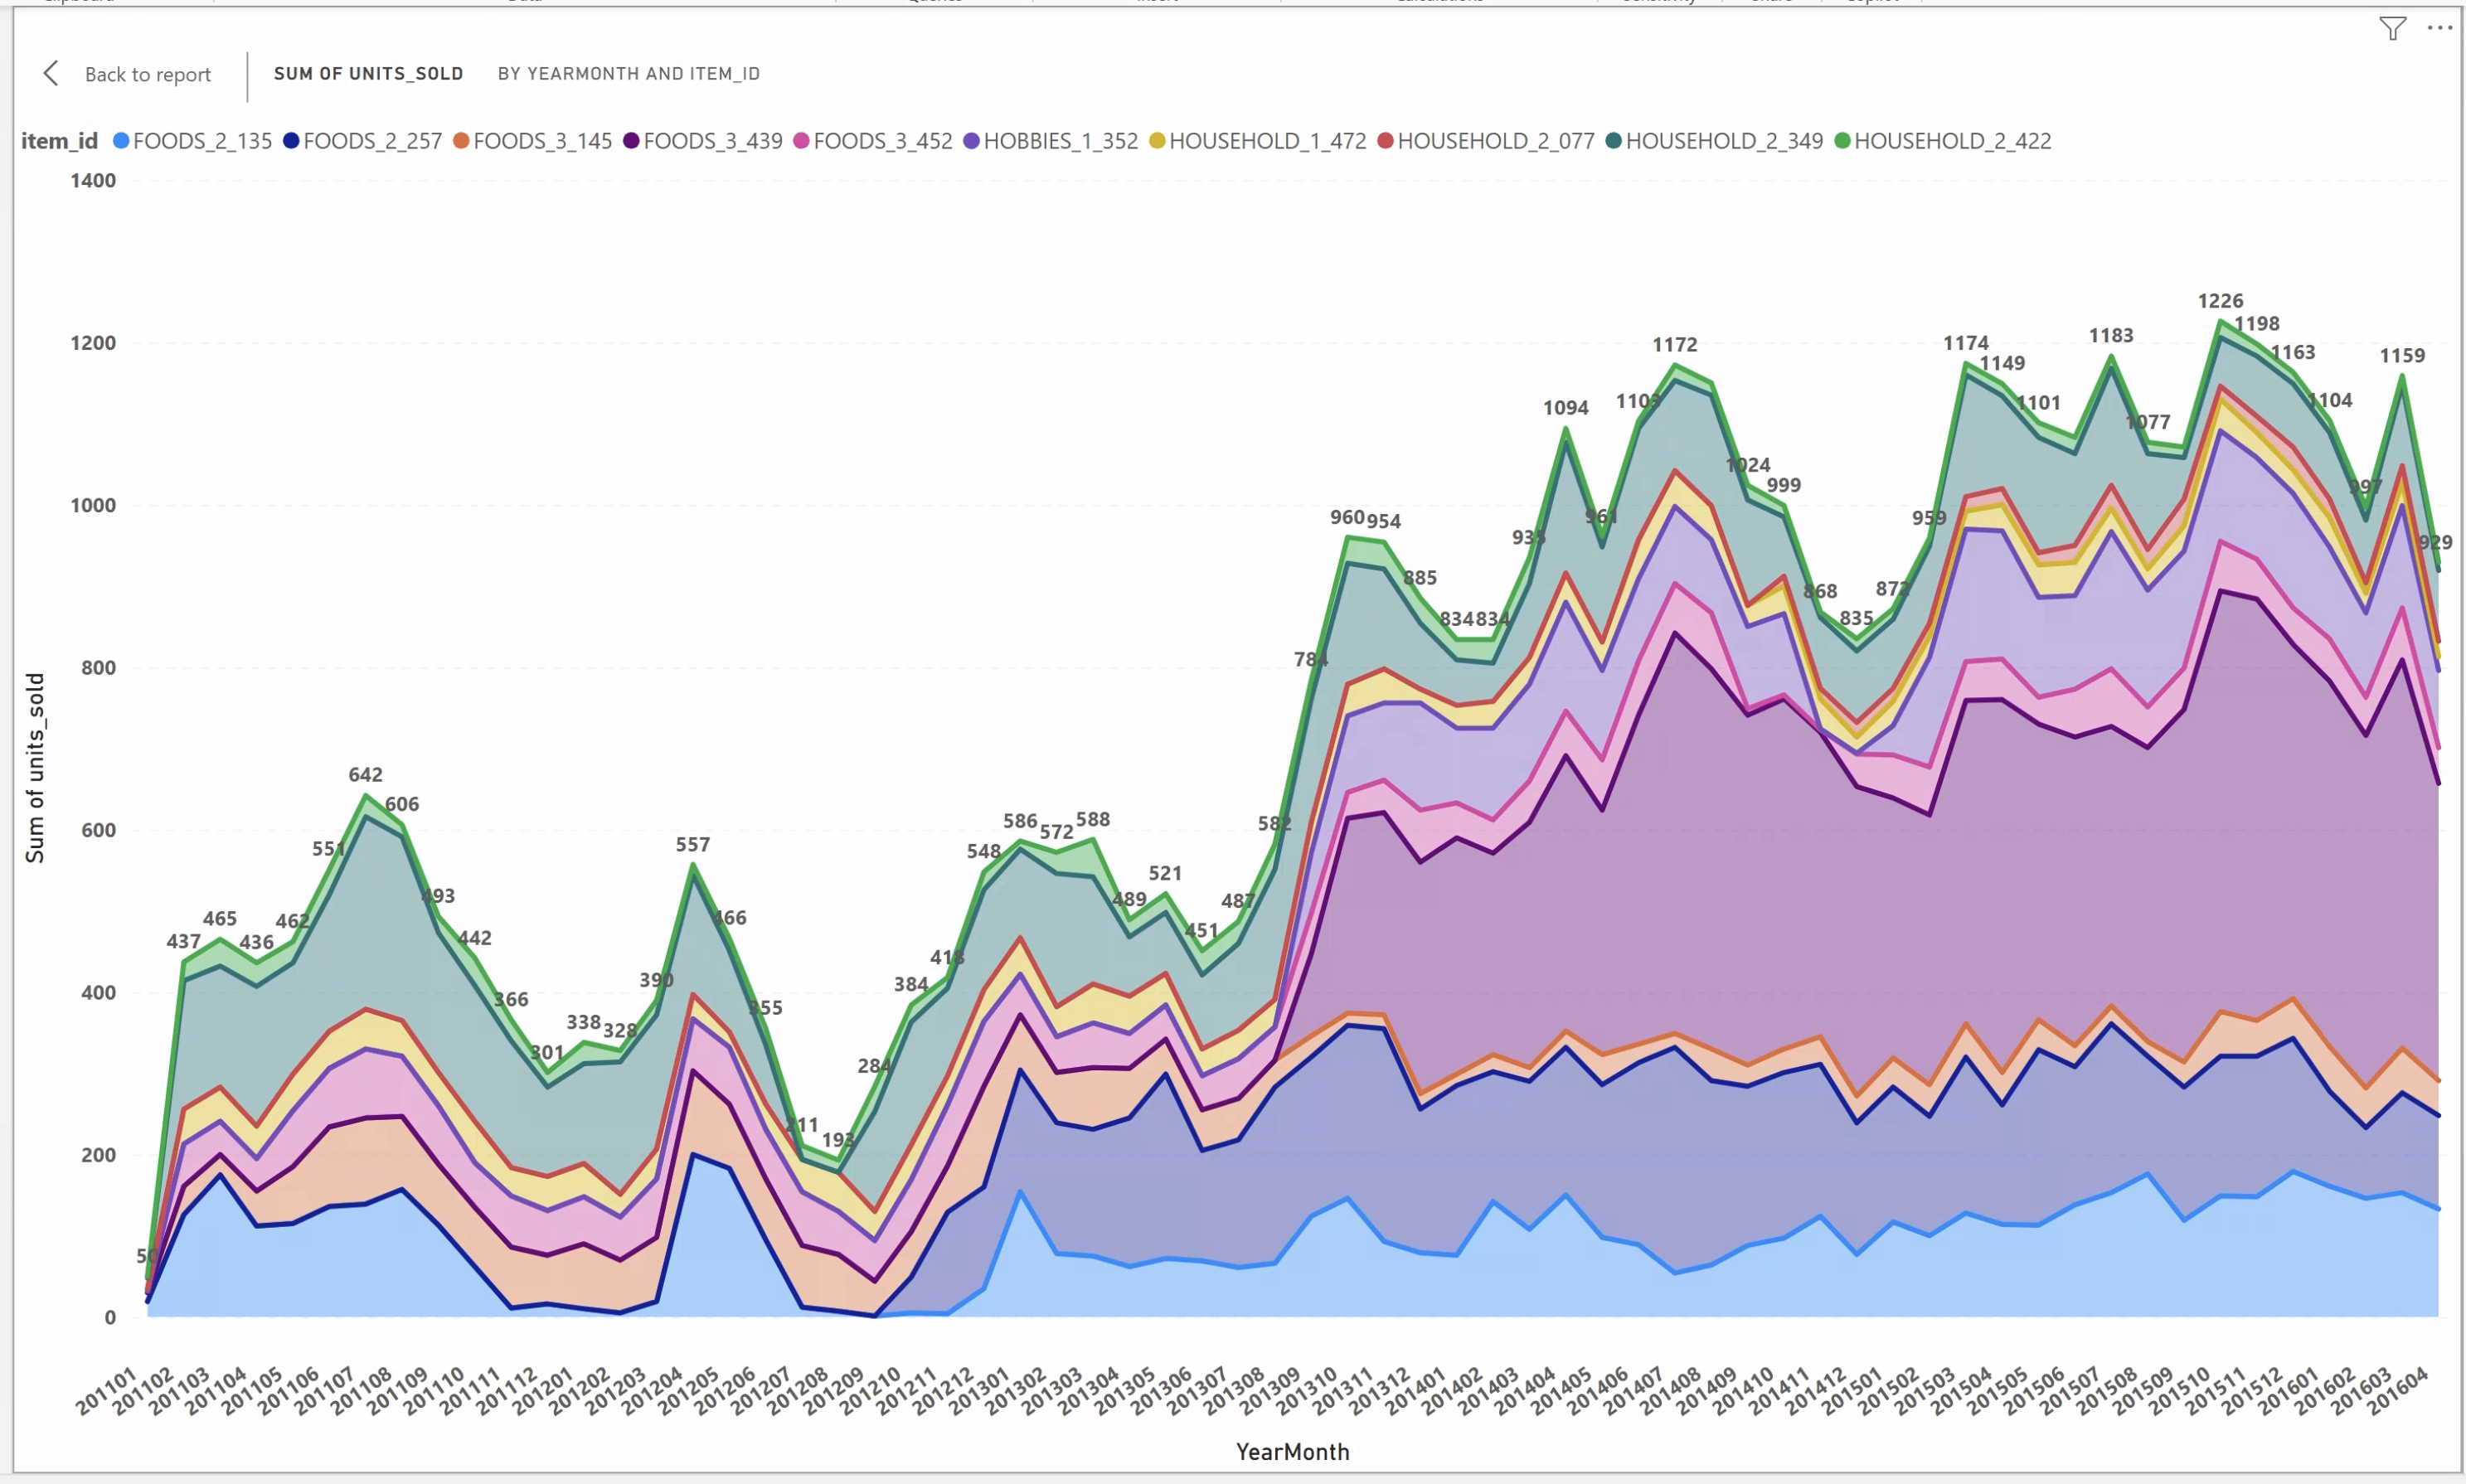

Pie Chart Total UNIT_SOLD by STORE_ID and CAT_ID

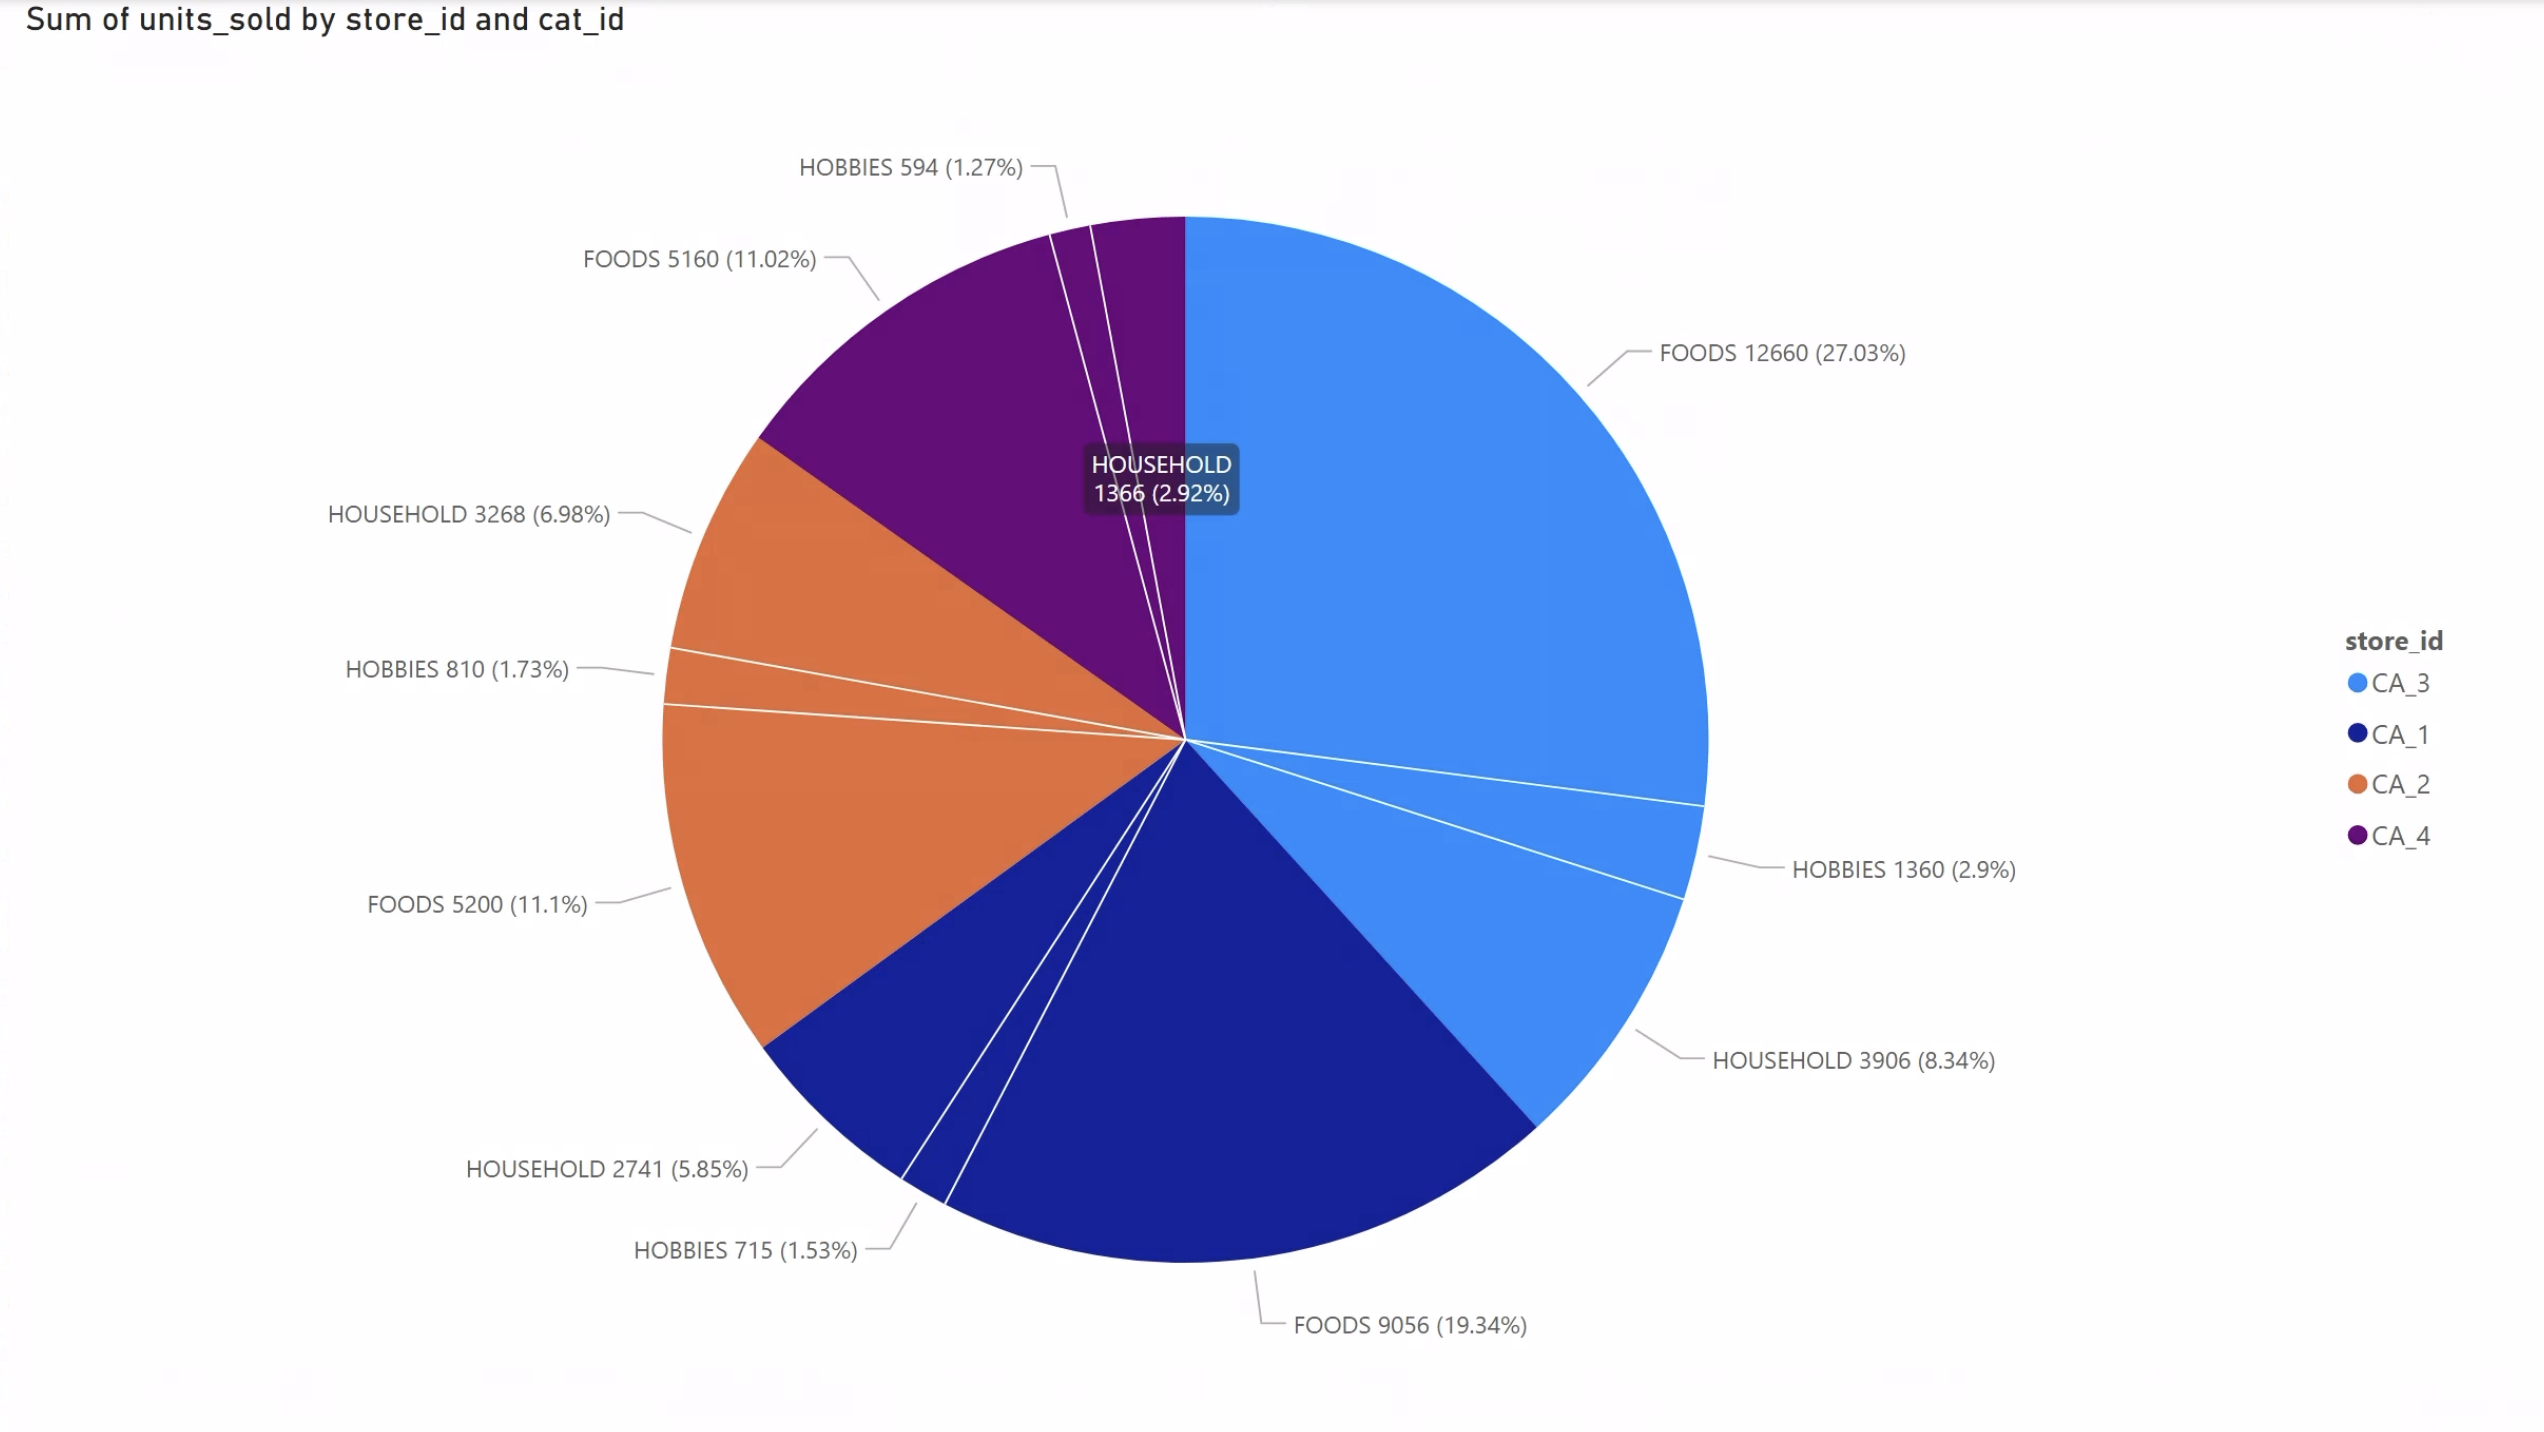

Box and Whiskey Plot for Total SELL_PRICE by ID,Store_ID and CAT_ID

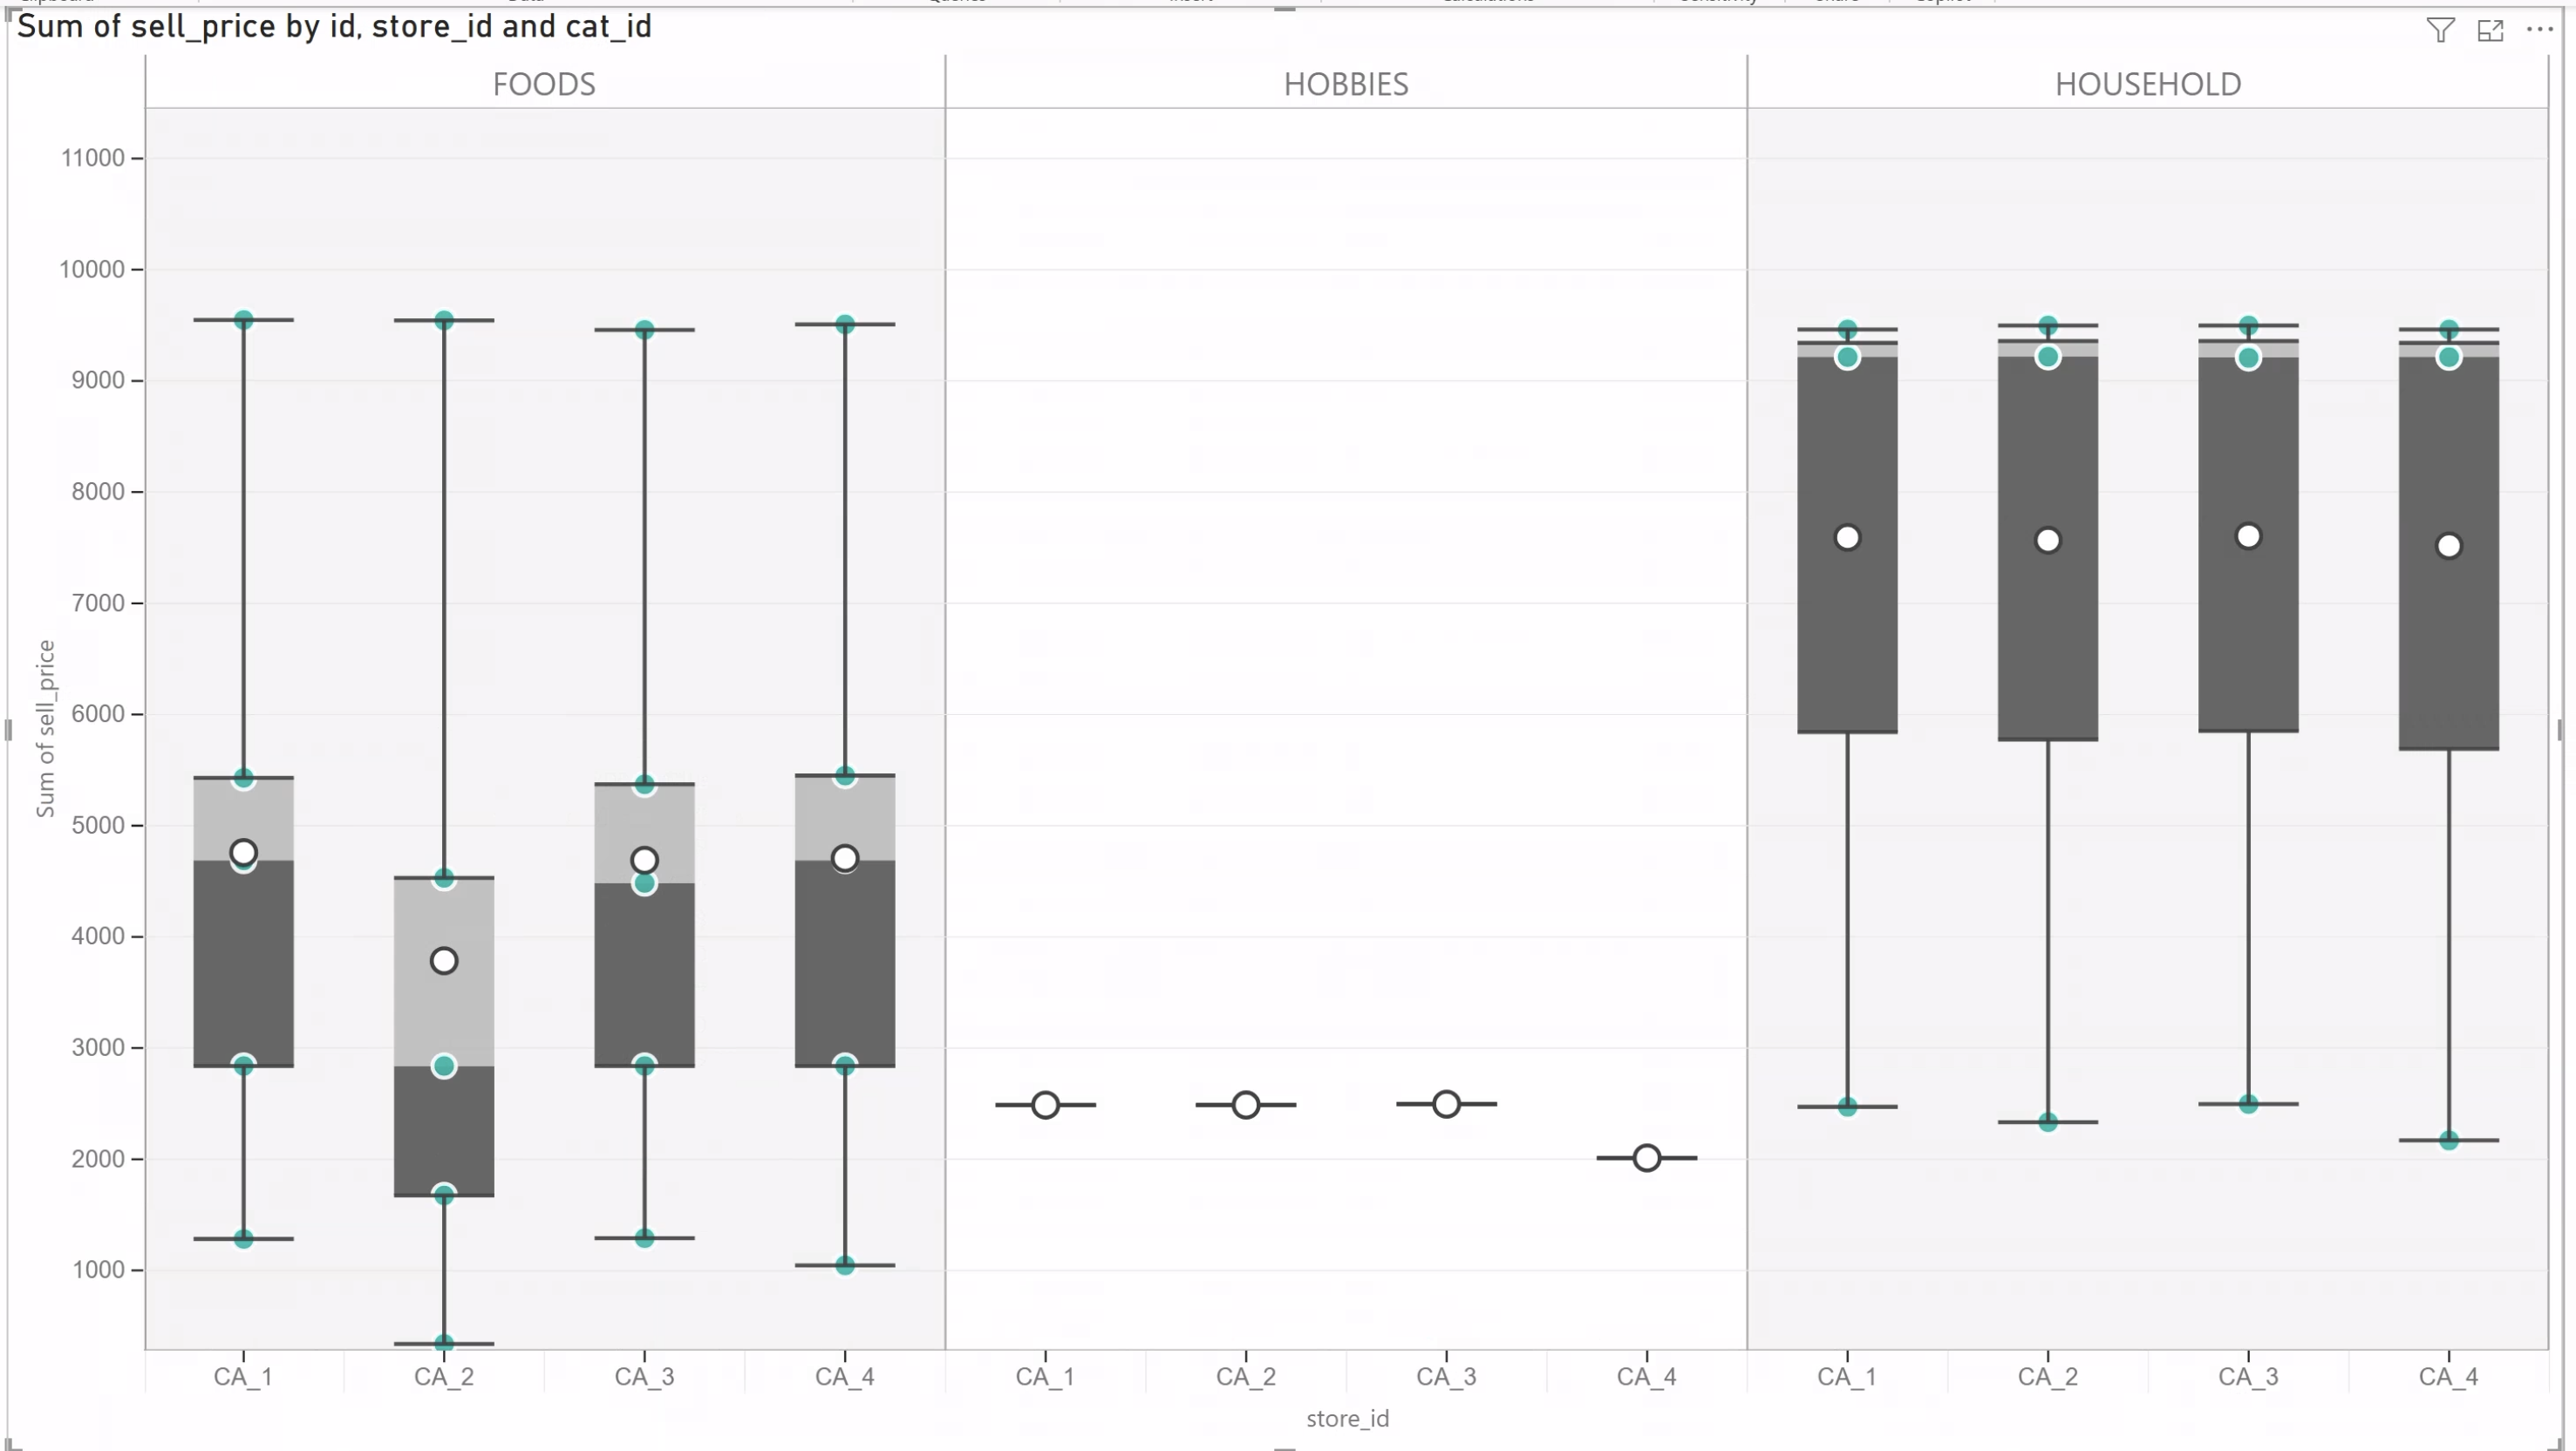

##Modeling with ARIMA

The pmdarima library contains a function called ```auto_arima```. This is a very handy function because it allows us to fit ARIMA models automatically without having to first identify the order of the hyperparameters. The function fits the models through a stepwise search and selects the model with the lowest AIC.






First we'll get some plots from our time series to see what we are working with.

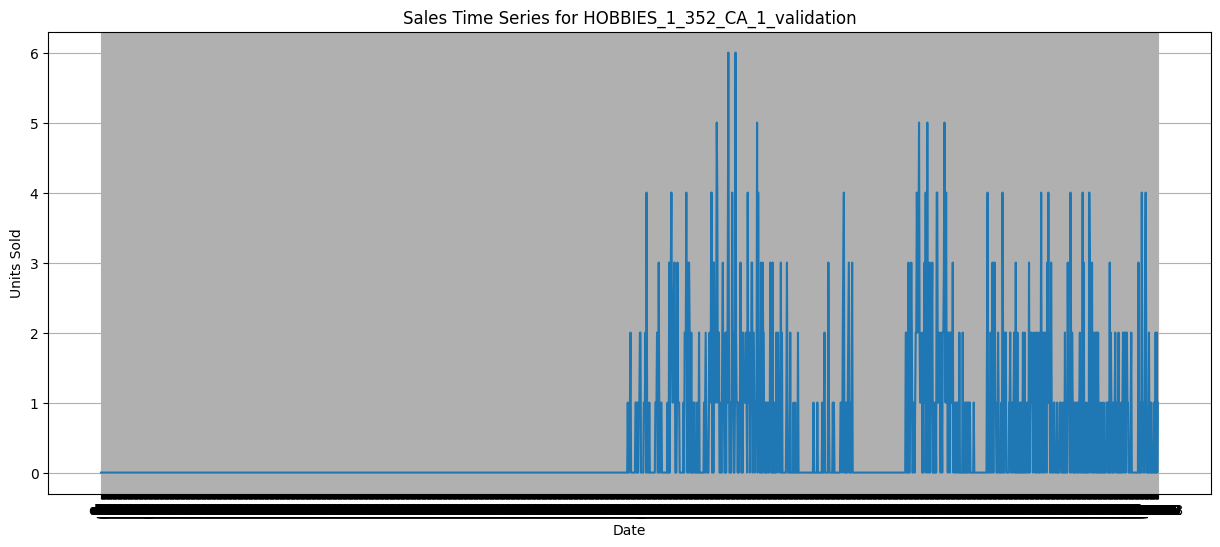

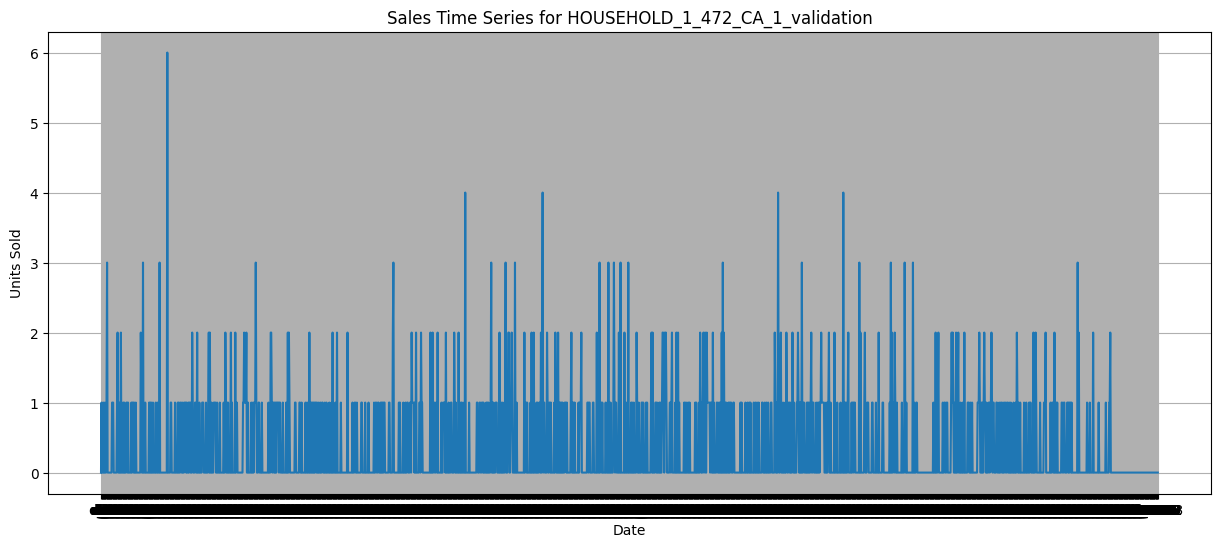

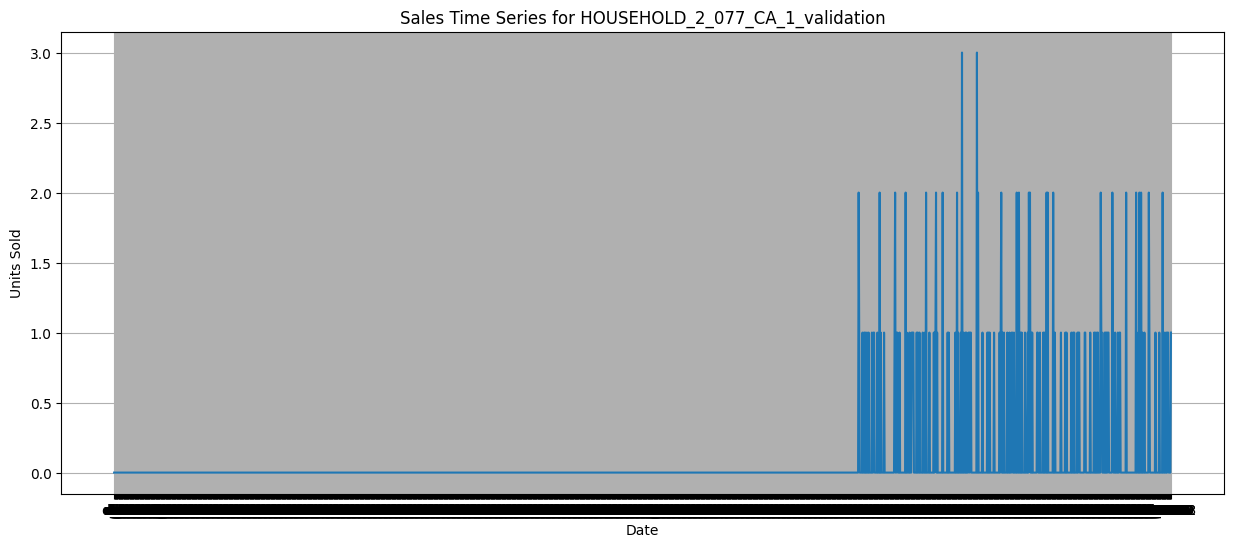

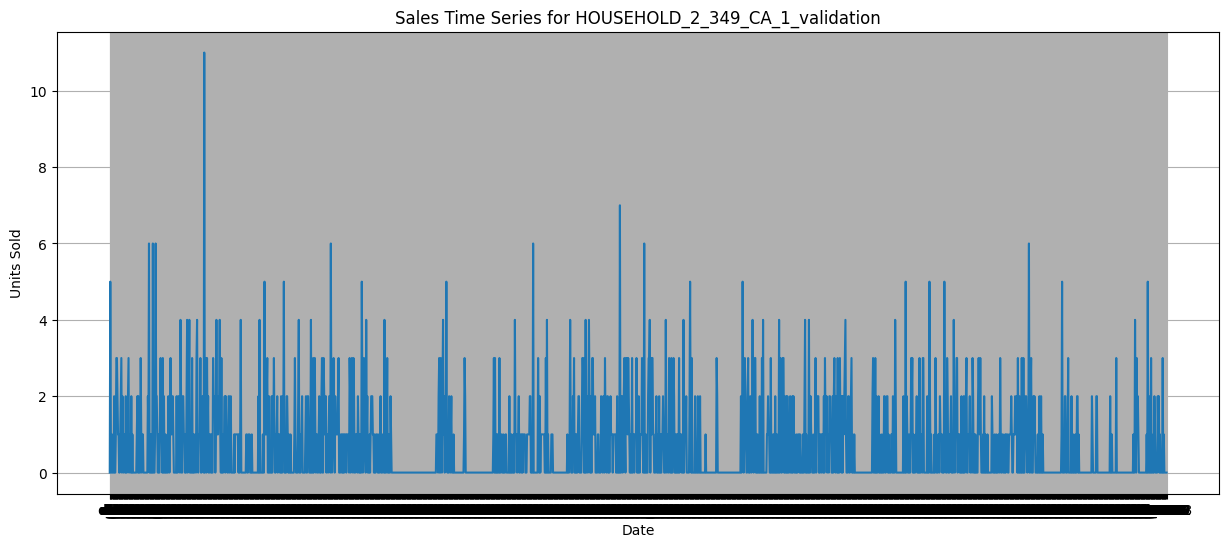

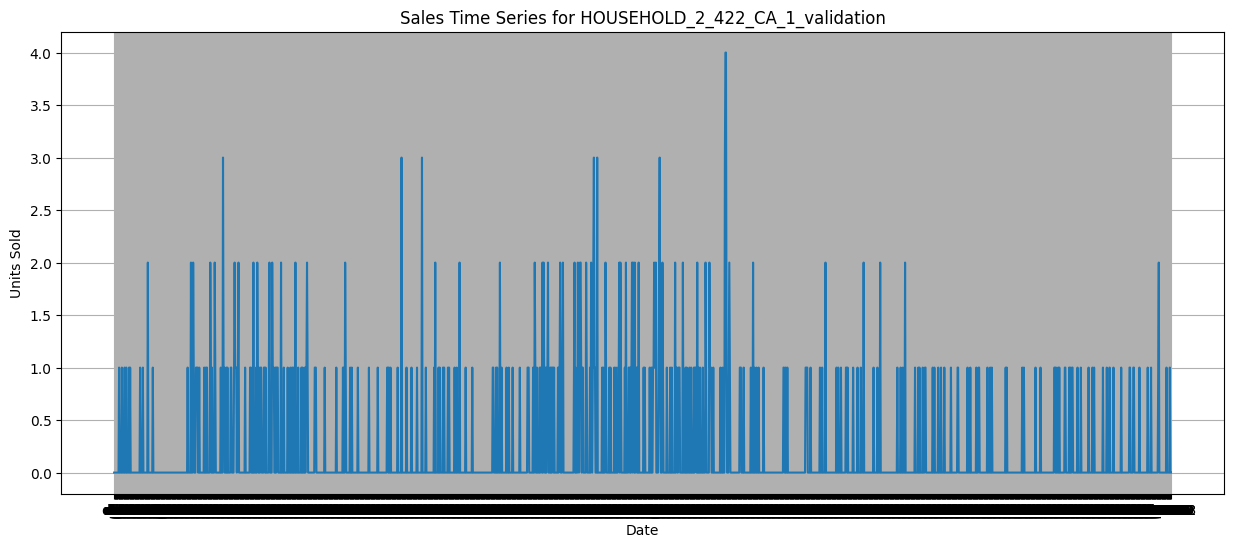

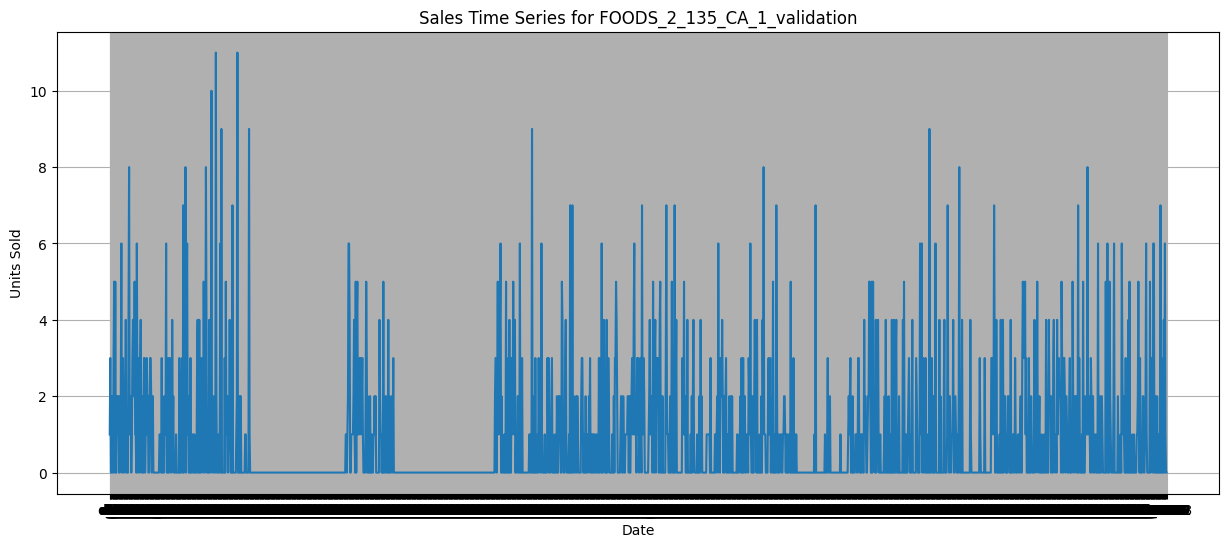

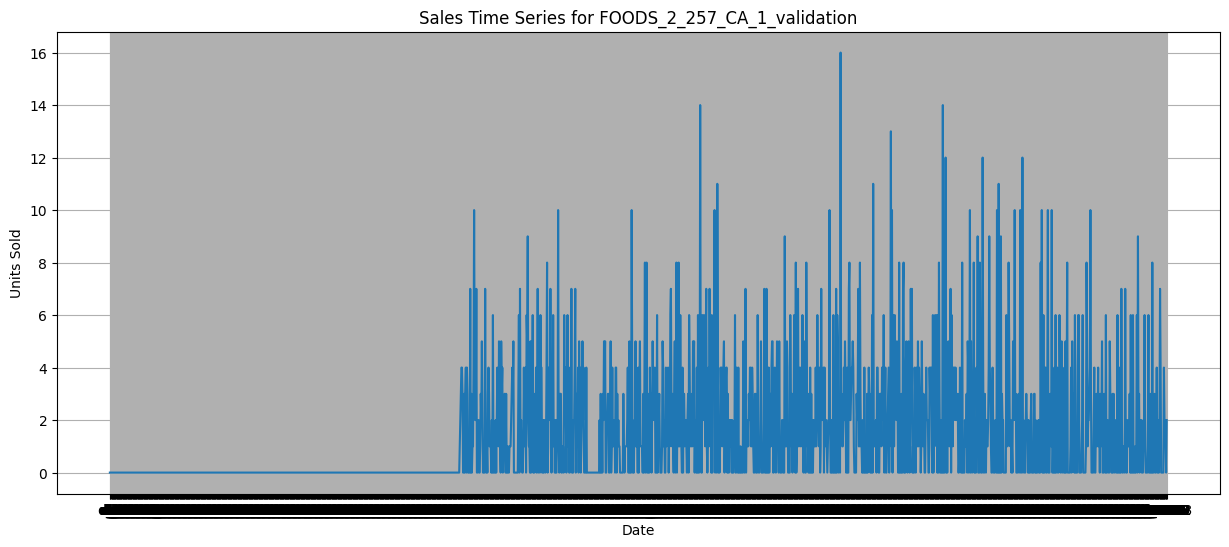

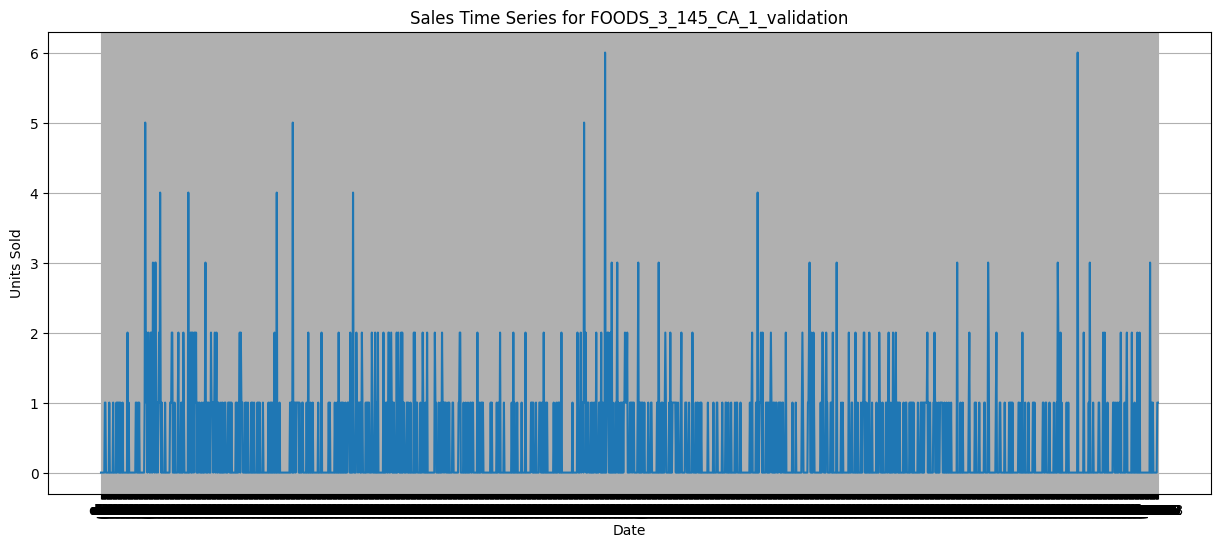

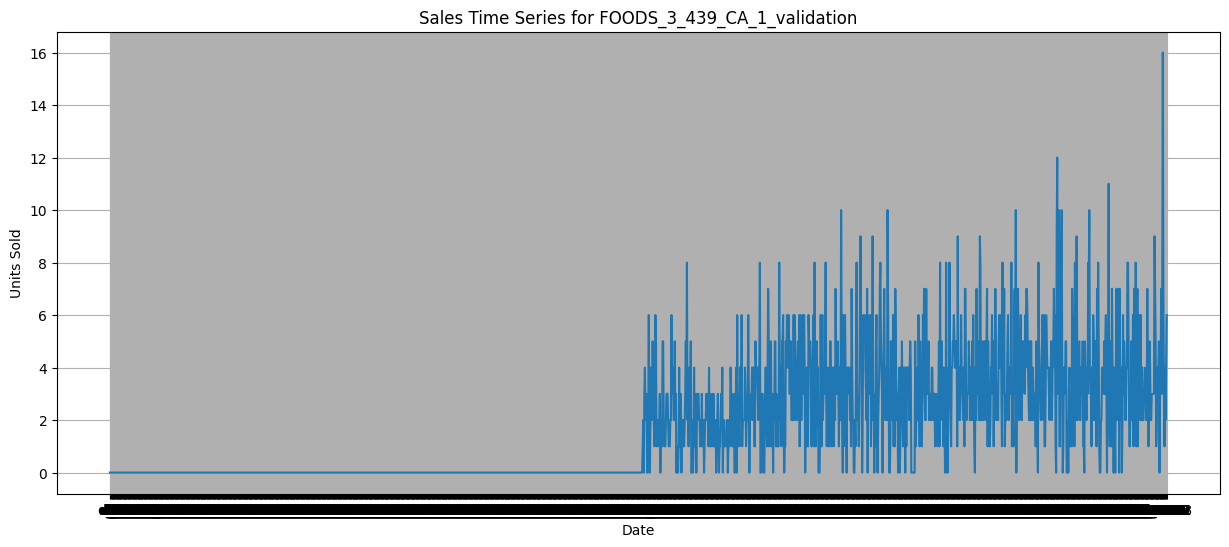

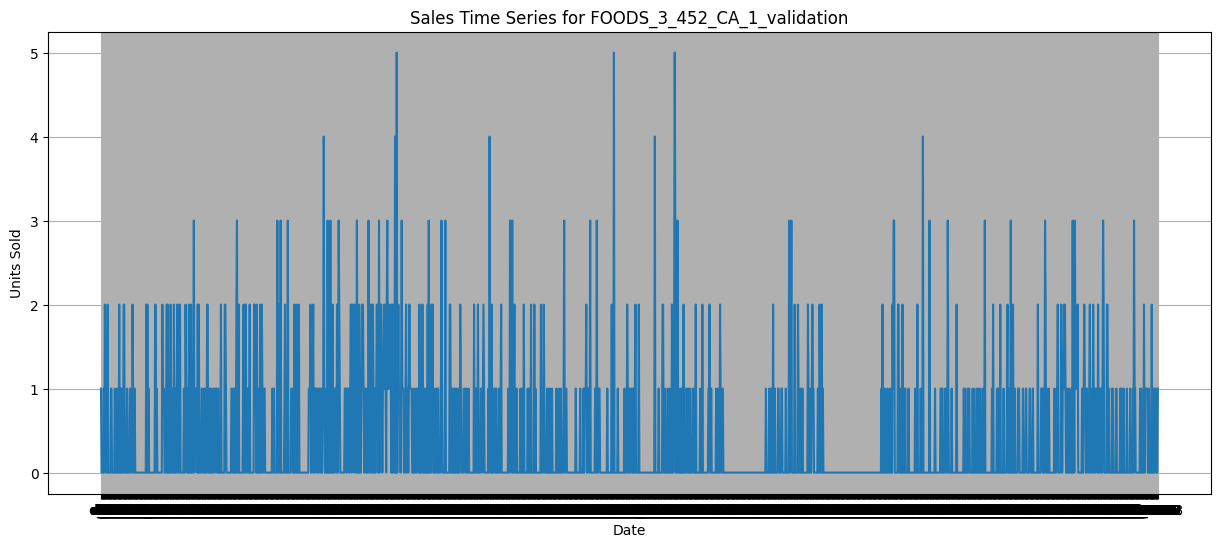

In [ ]:
#Define a function to plot each of the 10 time series in SalesFull
def plotTS(dataset):
  for index, row in dataset.iterrows():
    plt.figure(figsize=(15, 6))
    plot(row.index, row.values)

    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.title(f'Sales Time Series for {index}')
    plt.grid(True)
    plt.show()
plotTS(salesFull)

Figure 4: Plots of the time series for the sales each of our 10 randomly selected products from one of the California stores over all 1,913 days. The data shows no obvious trends, but does appear to exhibit some seasonality. Also worth noting is the sparsisity of each time series; this could prove to be an issue when fitting an ARIMA model.

Now we will use auto_arima to form the ARIMA models.

In [ ]:
modelTest = pm.auto_arima(salesFull.iloc[1],
                          seasonal = True,
                          m = 100,
                          stepwise = True,
                          suppress_warnings = True,
                          error_action = "ignore",
                          trace = True,
                          start_p=0, start_q=0, max_p=3, max_q=3)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[100] intercept   : AIC=5199.290, Time=52.44 sec
 ARIMA(0,1,0)(0,0,0)[100] intercept   : AIC=5198.560, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[100] intercept   : AIC=4615.374, Time=46.46 sec
 ARIMA(0,1,1)(0,0,1)[100] intercept   : AIC=3863.395, Time=113.65 sec
 ARIMA(0,1,0)(0,0,0)[100]             : AIC=5196.560, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[100] intercept   : AIC=3864.856, Time=0.84 sec
 ARIMA(0,1,1)(1,0,1)[100] intercept   : AIC=3865.479, Time=75.09 sec


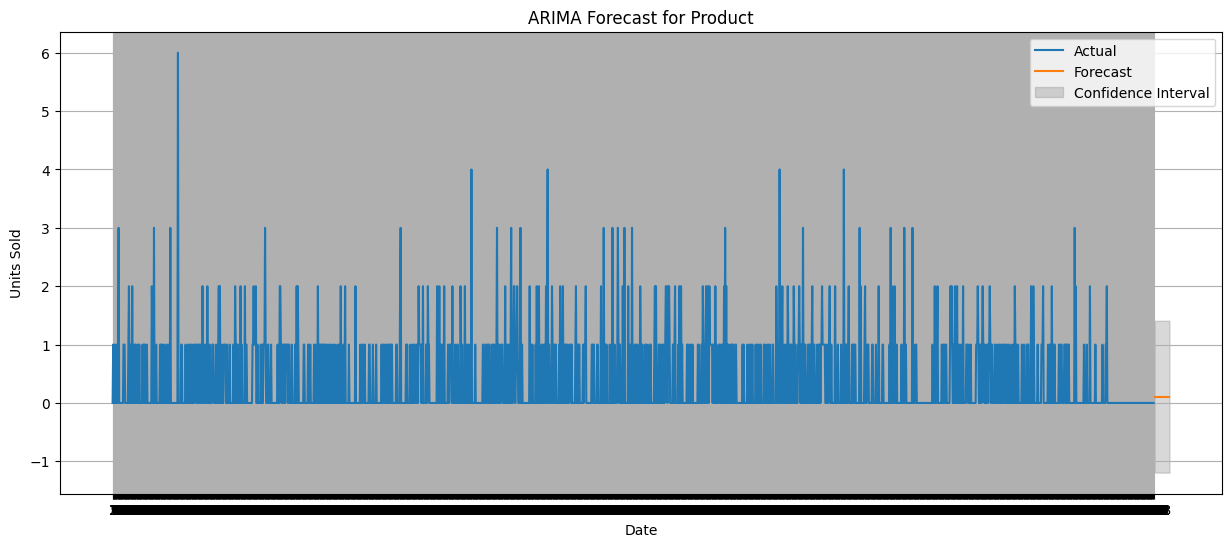

In [ ]:
# Forecast the next 28 days
future_dates = list(range(int(salesFull.columns[-1]) + 1, int(salesFull.columns[-1]) + 28 + 1, 1))
forecast, confInt = modelTest.predict(n_periods=28, return_conf_int=True)

lower_bound = pd.Series(confInt[:, 0], index=future_dates)
upper_bound = pd.Series(confInt[:, 1], index=future_dates)
    #Plot the forecasts with their confidence intervals
plt.figure(figsize=(15, 6))
plt.plot(salesFull.iloc[1].index, salesFull.iloc[1].values, label='Actual')
plt.plot(future_dates, forecast, label='Forecast')
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title(f'ARIMA Forecast for Product')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
arima_models = {}

for index, row in salesFull.iterrows():
    product_id = index  # 'id' is the index after pivoting
    series = row.values # The values for the time series

    # Use auto_arima to find the best ARIMA model parameters
    model = pm.auto_arima(series,
                          seasonal=True,       # Set to True if you expect seasonality
                          m=1,                # Set seasonal period (e.g., 7 for weekly)
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          trace=True)

                          #start_p=0, start_q=0, max_p=3, max_q=3) # Set trace to True to see the progress
    print(model.summary())
    # Store the fitted model
    arima_models[product_id] = model
    print(f"Fitted ARIMA model for product: {product_id}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4258.224, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5270.551, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4818.097, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4263.792, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5268.552, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4255.704, Time=4.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4254.567, Time=1.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4256.178, Time=1.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4254.234, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4255.966, Time=1.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4615.596, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4252.298, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4261.840, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4816.098, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]          

Now that we have our models, we can do some forecasting. ```salesEvalFull``` contains an additional 28 days to test our forecasts from ```salesFull```. So we will forecast our an additional 28 days.

[1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941]


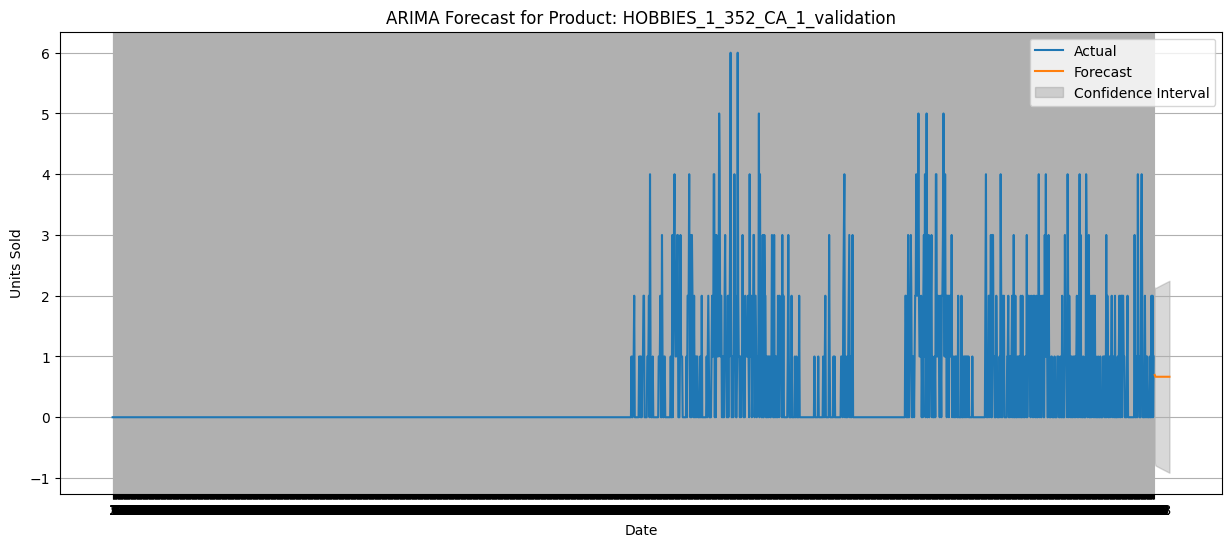

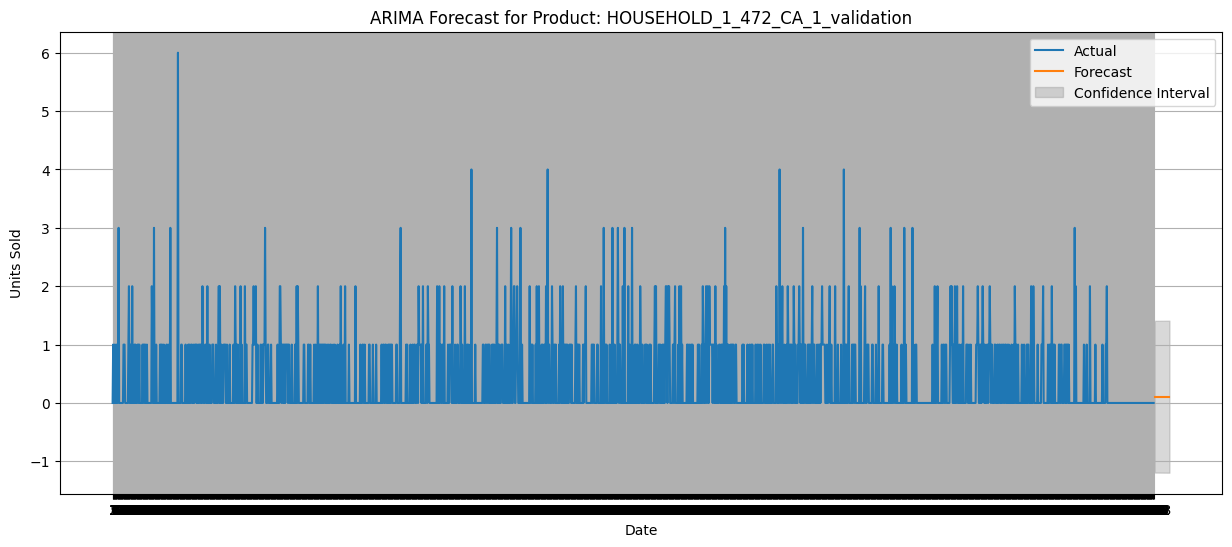

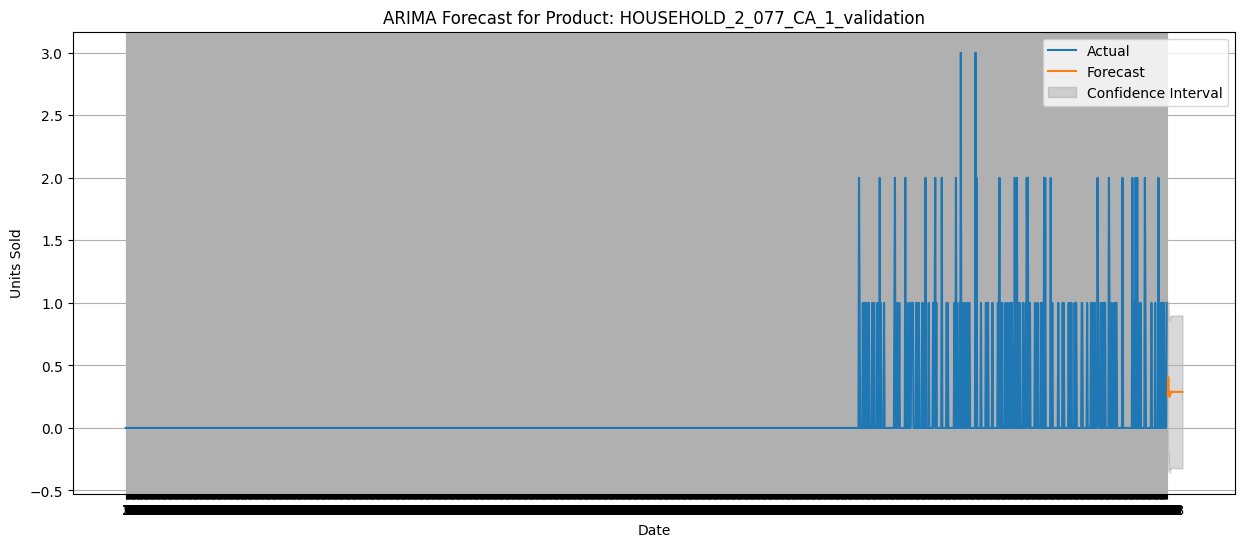

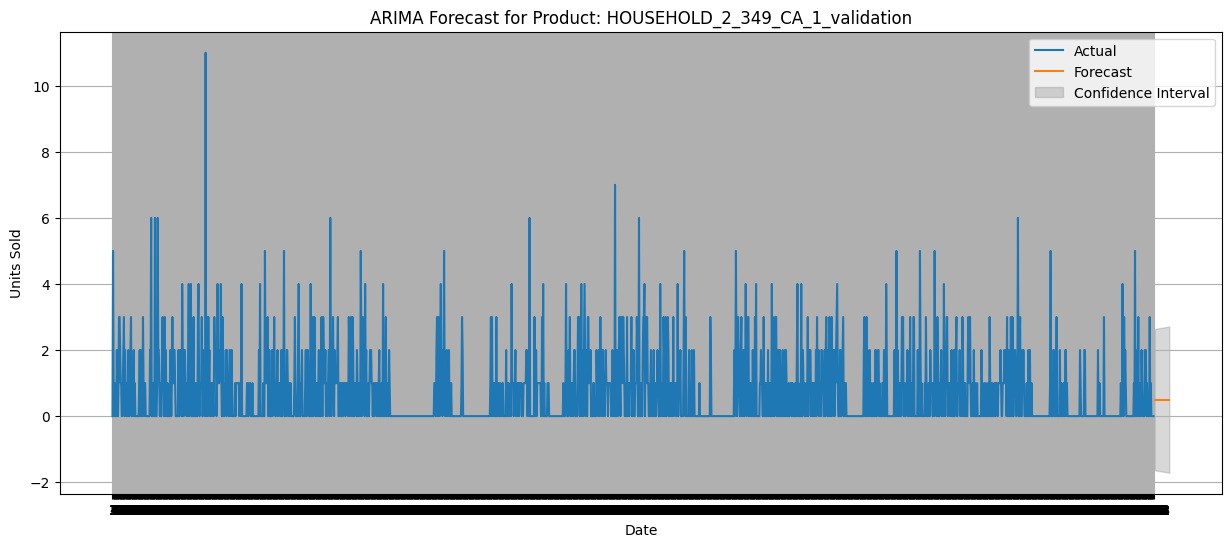

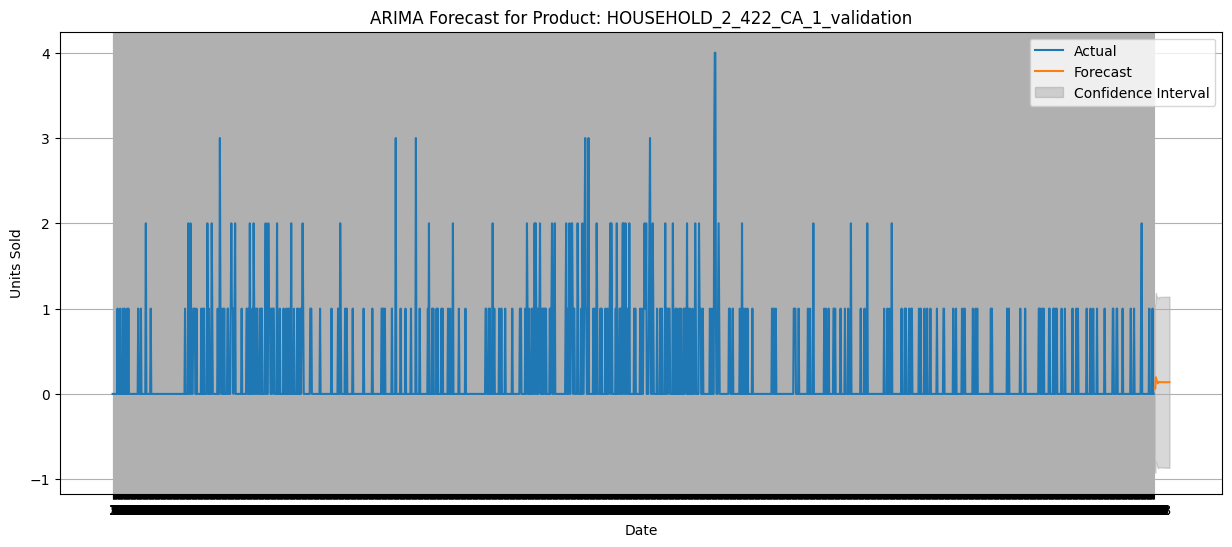

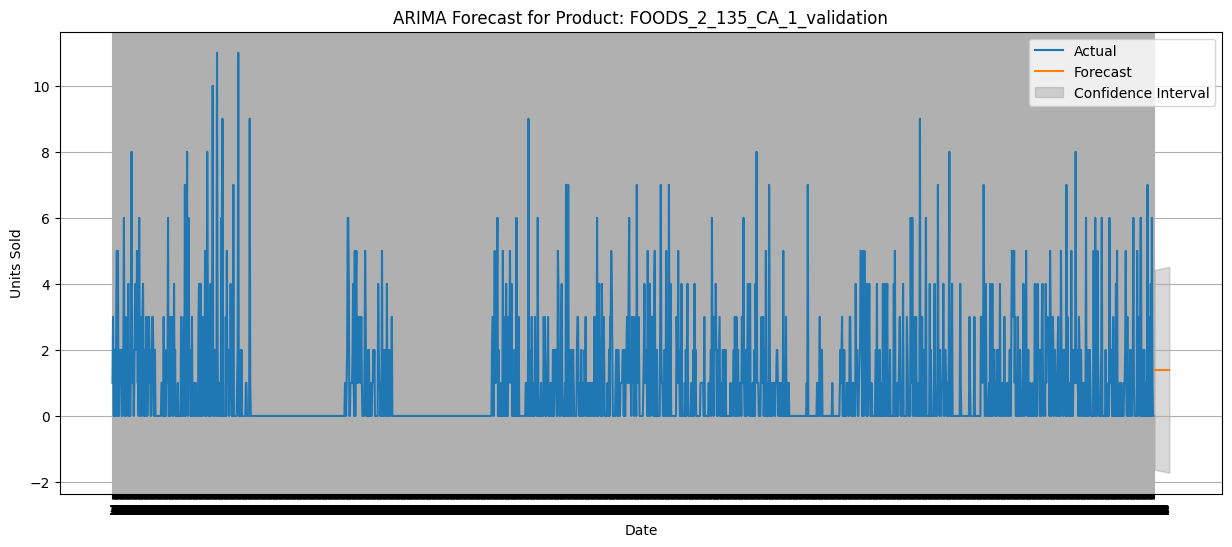

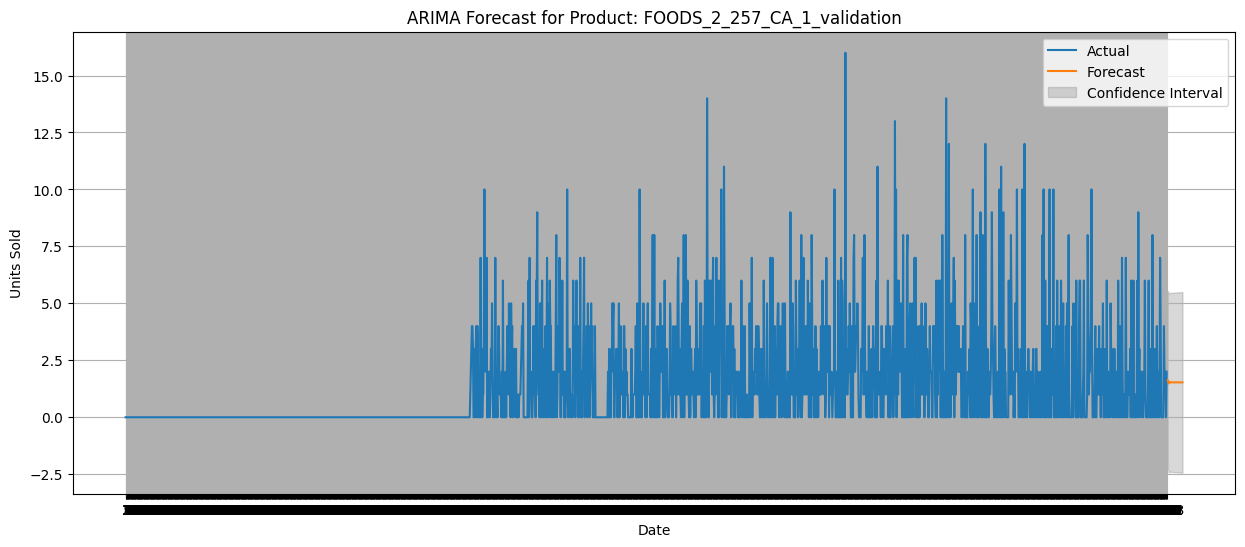

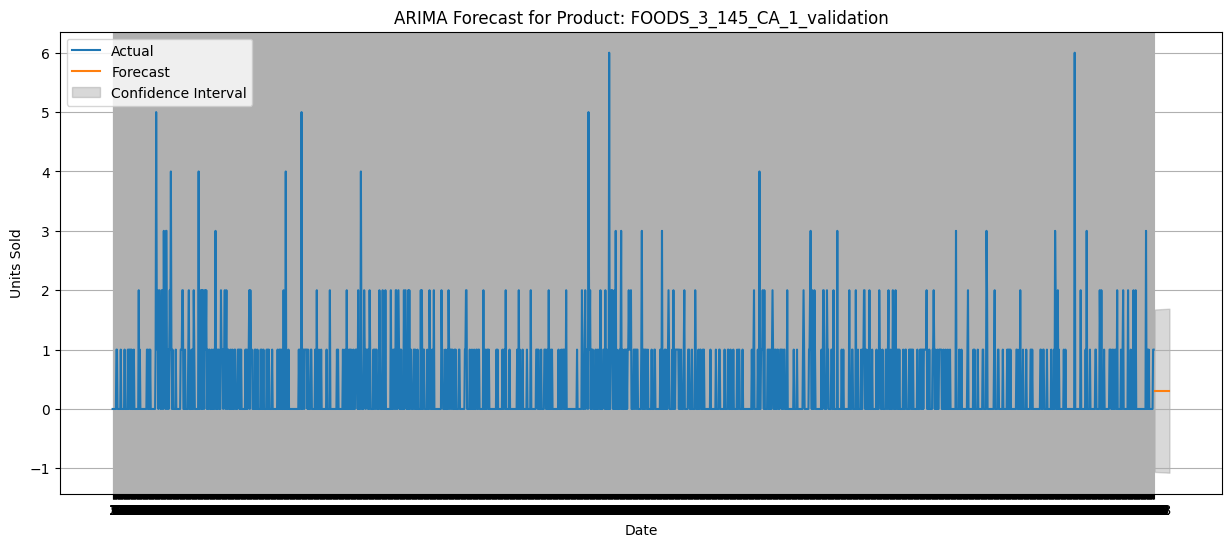

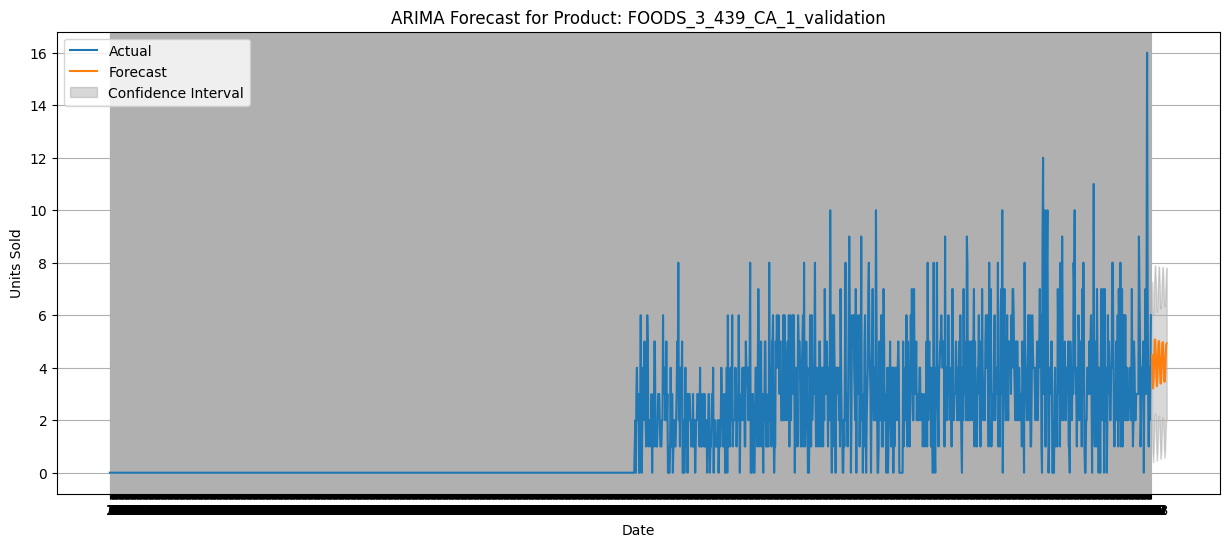

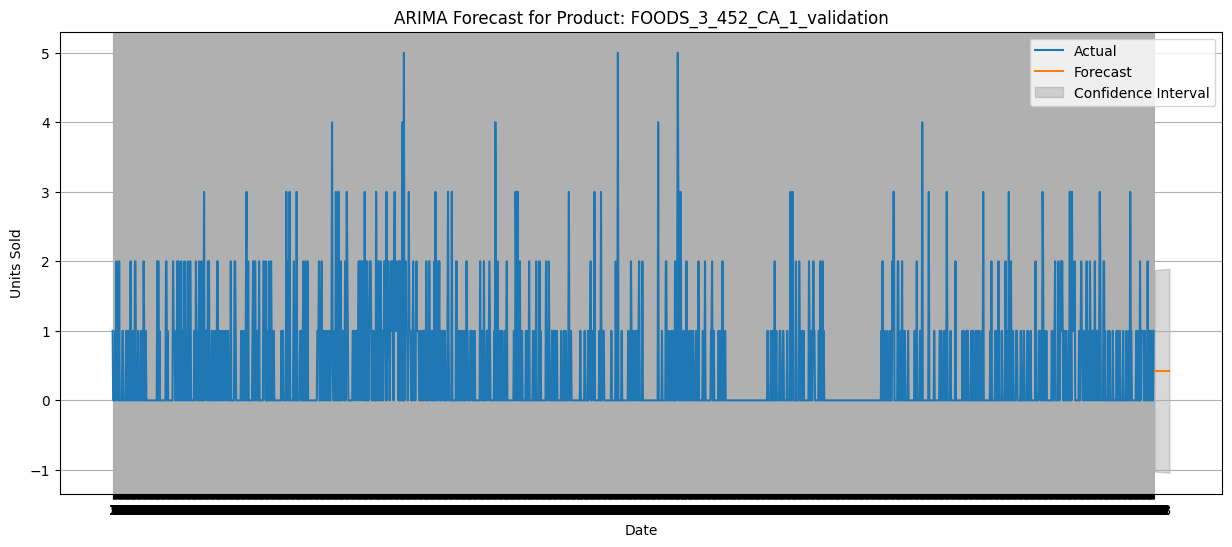

In [21]:
n_periods = 28
#Make date index for forecasts
future_dates = list(range(int(salesFull.columns[-1]) + 1, int(salesFull.columns[-1]) + 28 + 1, 1))
print(future_dates)
forecasts = []

for index, row in salesFull.iterrows():
    product_id = index
    current_model = arima_models[product_id]

    # Forecast the next 28 days
    forecast, confInt = current_model.predict(n_periods=n_periods, return_conf_int=True)
    forecasts.append(forecast)
    lower_bound = pd.Series(confInt[:, 0], index=future_dates)
    upper_bound = pd.Series(confInt[:, 1], index=future_dates)
    #Plot the forecasts with their confidence intervals
    plt.figure(figsize=(15, 6))
    plt.plot(row.index, row.values, label='Actual')
    plt.plot(future_dates, forecast, label='Forecast')
    plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.title(f'ARIMA Forecast for Product: {product_id}')
    plt.legend()
    plt.grid(True)
    plt.show()


Figure 5: ARIMA forecasts for our 10 products. At first glance, it does not appear that our models capture the volatility of the data well, though some plots do better than others. This could very well be due to the sparsity of these time series, a feature which ARIMA models are known to struggle with. The confidence intervals; however, do appear wide enough to reflect this volatility.

We will now compare our forecasts with the actual units sold.

In [11]:
#Strip out all the observations from evaluation after day 1913
evaluationForecasts = salesEvalFull.iloc[:, 1913:]
evaluationForecasts.head()

1914  1915  1916  1917  1918  1919  1920  \
id                                                                          
HOBBIES_1_352_CA_1_validation       1     0     0     1     0     0     4   
HOUSEHOLD_1_472_CA_1_validation     0     0     0     0     0     0     0   
HOUSEHOLD_2_077_CA_1_validation     0     0     0     1     1     2     0   
HOUSEHOLD_2_349_CA_1_validation     0     0     0     0     0     2     3   
HOUSEHOLD_2_422_CA_1_validation     0     0     0     0     1     0     0   

                                 1921  1922  1923  ...  1932  1933  1934  \
id                                                 ...                     
HOBBIES_1_352_CA_1_validation       1     2     2  ...     1     2     3   
HOUSEHOLD_1_472_CA_1_validation     0     1     1  ...     0     0     0   
HOUSEHOLD_2_077_CA_1_validation     0     1     0  ...     1     0     0   
HOUSEHOLD_2_349_CA_1_validation     0     0     1  ...     0     2     1   
HOUSEHOLD_2_422_CA_1_validation     0     0     0  ...     0     2     0   

                                 1935  1936  1937  1938  1939  1940  1941  
id                                                                         
HOBBIES_1_352_CA_1_validation       1     0     0     2     1     1     1  
HOUSEHOLD_1_472_CA_1_validation     0     0     0     0     0     0     0  
HOUSEHOLD_2_077_CA_1_validation     0     0     0     1     0     0     0  
HOUSEHOLD_2_349_CA_1_validation     2     3     3     0     0     0     0  
HOUSEHOLD_2_422_CA_1_validation     0     2     0     0     0     0     0  

[5 rows x 28 columns]

In [12]:
evaluationForecasts.columns = evaluationForecasts.columns.astype(int) # Convert to integers

'3'

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


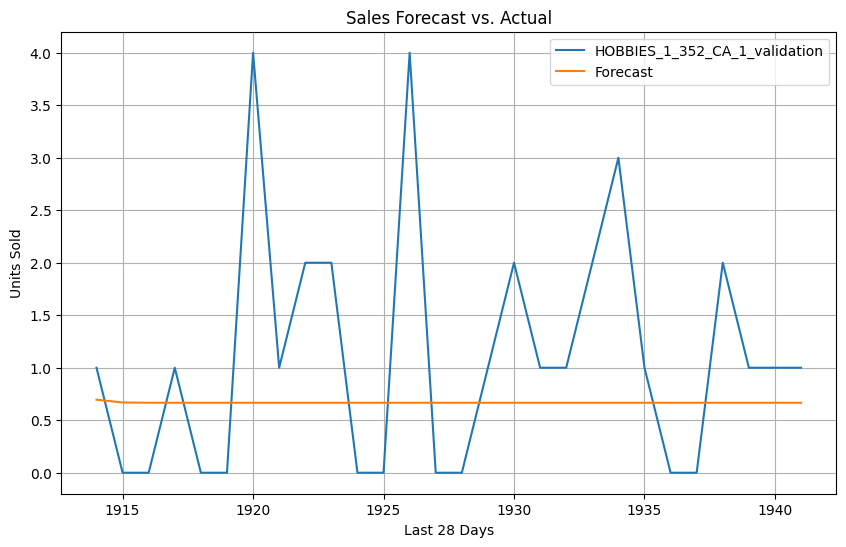

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


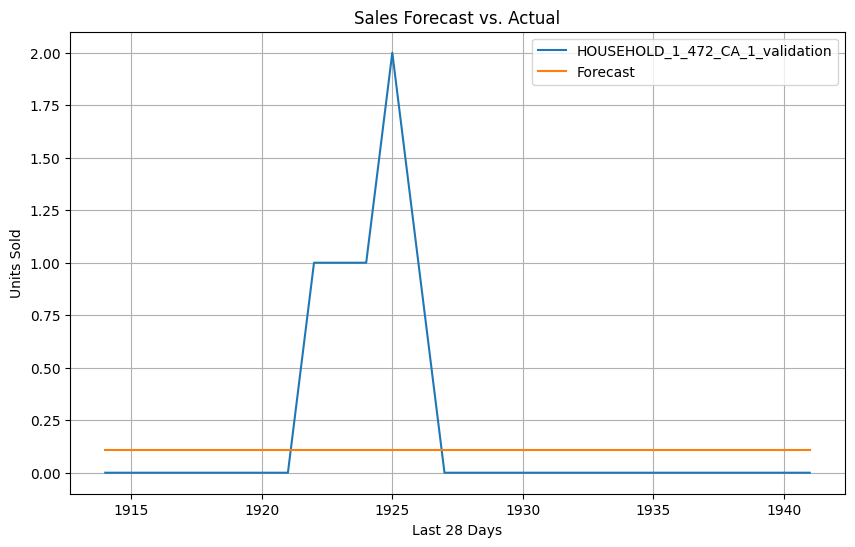

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


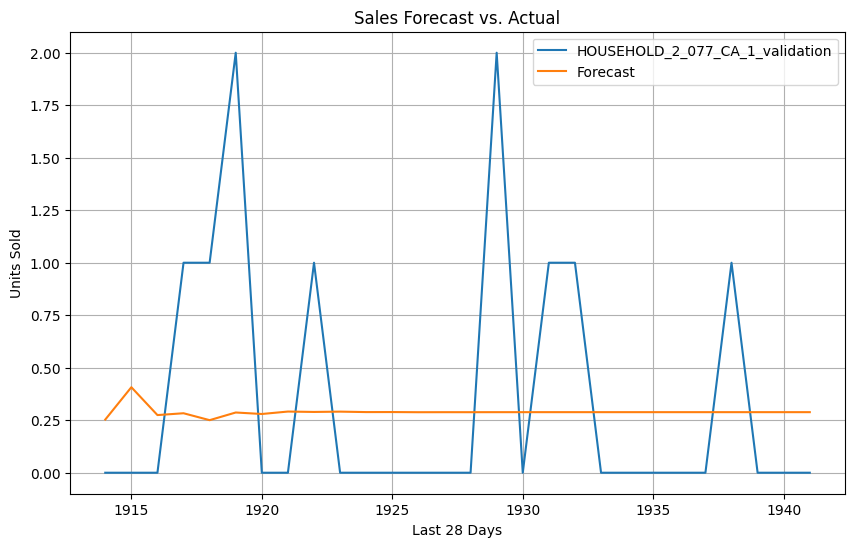

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


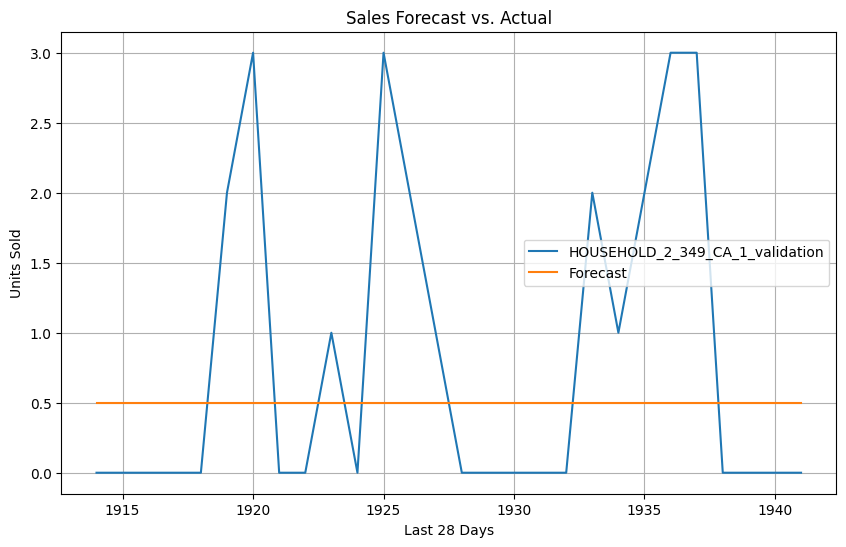

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


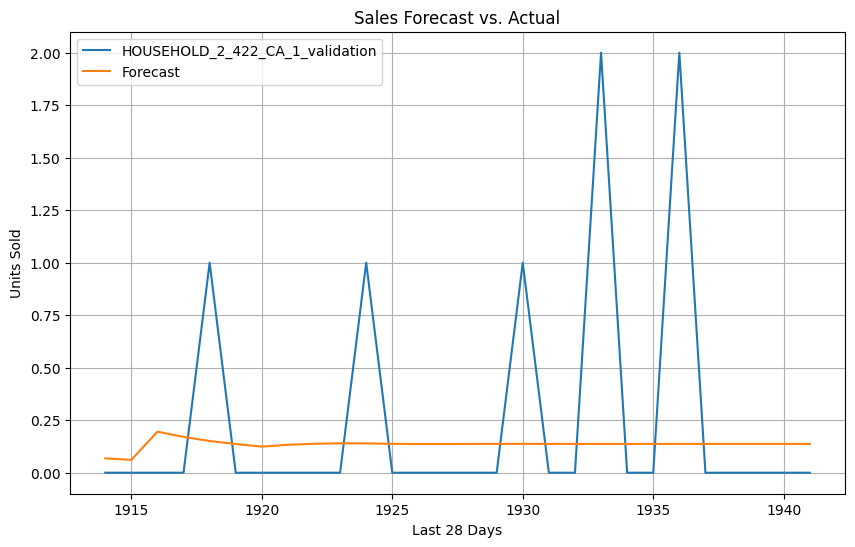

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


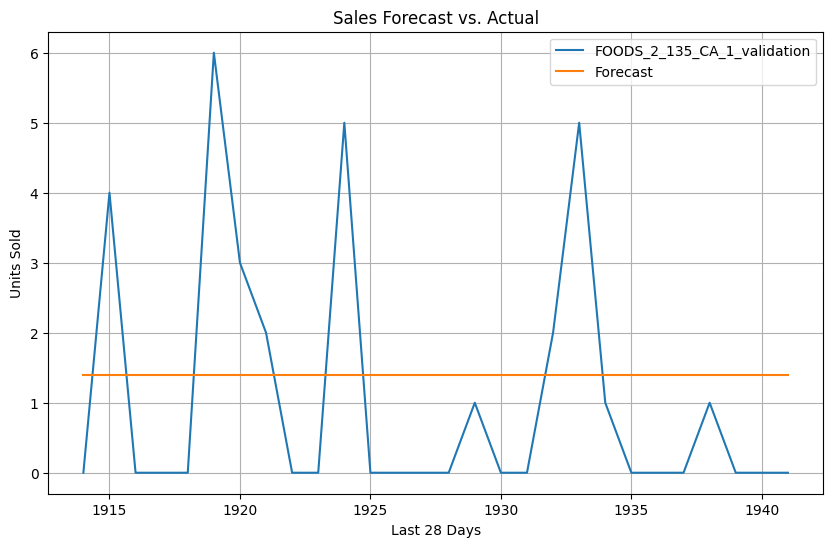

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


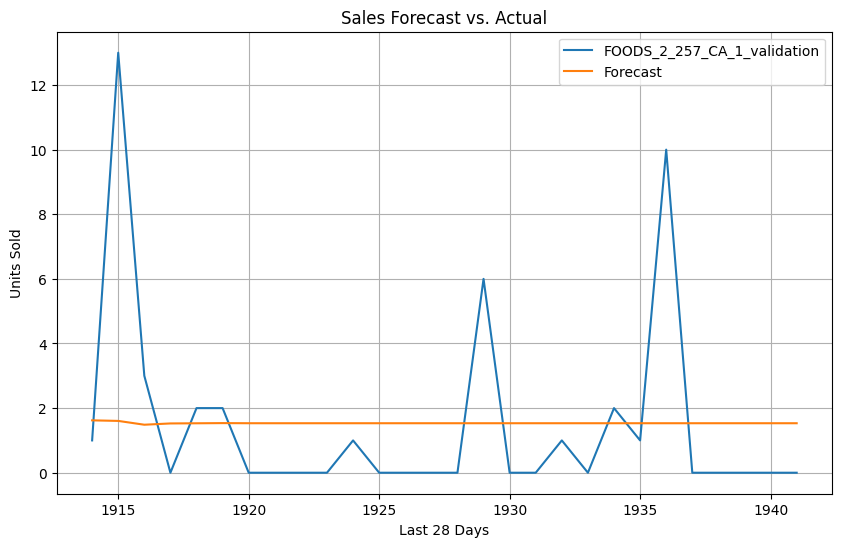

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


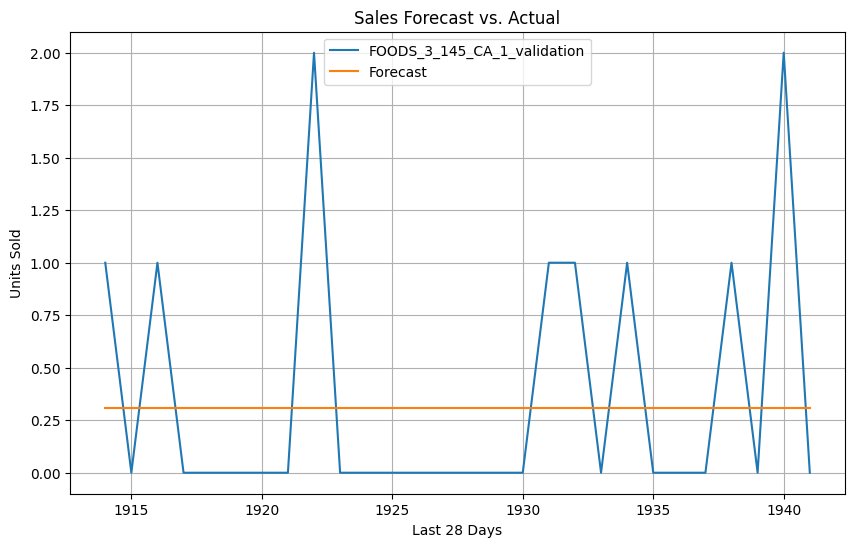

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


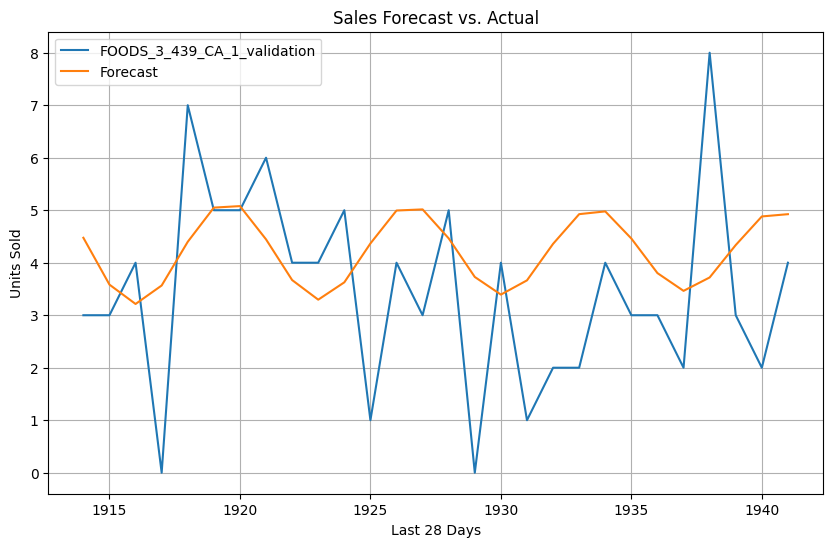

Index([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941],
      dtype='int64')


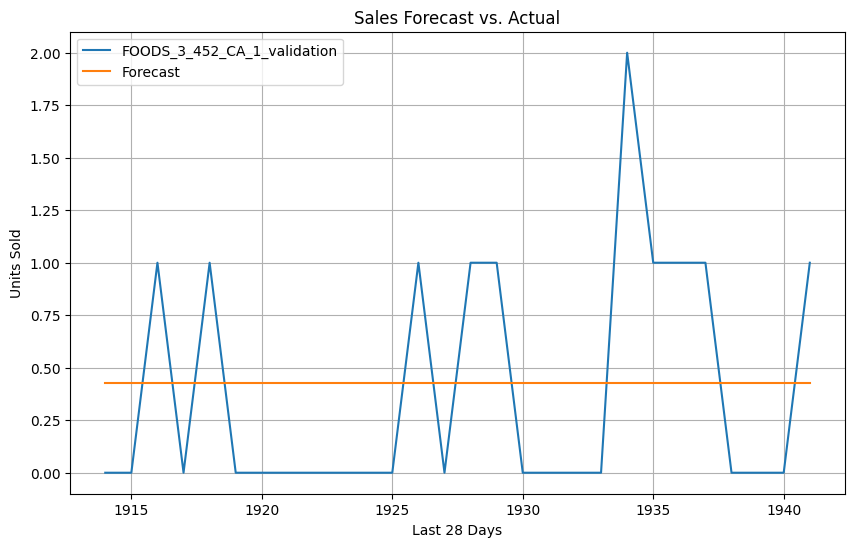

In [22]:
#Compare the forecasts with evaluationForecasts
def compare_forecasts(actual_sales, forecast, item_name):
    """
    Compares forecasted sales with actual sales and plots the results.
    Also generates a few comparison metrics.
    """
    # Ensure both have the same date range
    common_index = actual_sales.index.intersection(forecast.index)
    print(common_index)
    actual_sales = actual_sales.loc[common_index]
    forecast = forecast.loc[common_index]

    plt.figure(figsize=(10, 6))
    plt.plot(actual_sales, label=item_name)
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Last 28 Days')
    plt.ylabel('Units Sold')
    plt.title(f'Sales Forecast vs. Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert the list of forecasts into a DataFrame, using the salesFull1 index
forecasts_df = pd.DataFrame(forecasts, index = evaluationForecasts.index, columns=future_dates)


# Iterate through the product IDs (index of evaluationForecasts)
for product_id in evaluationForecasts.index:
    # Get the actual sales series for this product from evaluationForecasts
    actual_sales_series = evaluationForecasts.loc[product_id]
    # Get the forecasted sales series for this product from the forecasts_df
    forecast_series = forecasts_df.loc[product_id]

    # Now compare the series
    compare_forecasts(actual_sales_series, forecast_series, product_id)

Figure 6: Plots of the forecasts alongside the true values. As stated before, it appears that the ARIMA is not reflecting the volatility of the data, although it does better in cases such as FOODS_3_439 where it shows a constant oscillating pattern.